# Two-Dim Gaussian Interpolation
### Sub-steps:
**1)** *Build the grid time x wavelength using flux calibrated spectra, UV photometry and optical photometry (only where spectrophotometry is sparse)*

**2)** *Model the data using 2dim GPs and determine the 2dim interpolated surface*

**3)** *Predict UV extension for your sparse spectrophotometry*

**4)** *Predict additional spectra at the phases where spectrophotometry is sparse (FROM sparse spectrophotometry ---> TO spectrophotometry with high and homogeneous cadence)*

In [1]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/4_LCs_late_extrapolated/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

PRIORs_PATH = COCO_PATH+'Inputs/2DIM_priors'
OUTPUT_DIR = COCO_PATH+"Outputs/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
sys.path.insert(0, COCO_PATH+'/Codes/')
import what_the_flux as wtf
import GP2dim_utils as GP2dim


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
from collections import OrderedDict

from numpy.linalg import inv
from scipy import misc

import math

import scipy
from scipy import interpolate
from scipy import integrate
import scipy.optimize as opt
from scipy.optimize import minimize
from itertools import cycle

import george
from george.kernels import Matern32Kernel
%matplotlib inline

In [3]:
CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']
pre_bump = ['SN2011dh','SN1993J','SN2008D','SN2011fu','SN2006aj','SN1987A','SN2013df']

In [4]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o','Bessell_B': 'o', 'Bessell_V':'o', 'Bessell_R':'o', 'Bessell_I': 'o', 
             'sdss_g':'s','ptf_g':'s', "sdss_g'":'s', 'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s', 'sdss_z':'s', "sdss_z'":'s', 'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o', 'Ks':  'o','K':  'o',
                'swift_UVW1':'D', 'swift_UVW2':'D', 'swift_UVM2':'D', 'swift_U':'D',
                'swift_V':'D', 'swift_B':'D'}

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']
#exclude_filt = ['KS']

convert2mjd = (lambda x: float(x.replace('_REmangled_spec.txt','')\
                               .replace('_REmangled_spec_FL.txt','')\
                               .replace('_mangled_spec.txt','')))

In [5]:
def calc_lam_eff(wls, transmission):
    return (integrate.trapezoid(transmission*wls, wls)/\
            integrate.trapezoid(transmission, wls))

In [14]:
class FullMangledSeries_Class():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, snname, type_=None, spec_file=None, 
                 mode = 'extend_spectra' , verbose=False, DELTA=50.):
        """
        mode: 'extend_spectra'  or 'extrapolate_spectra' 
        """
        ## Initialise the class variables            
        self.snname = snname
        self.SNtype = type_
        self.mode = mode
        self.get_mangledspec_list()
        self.DELTA = DELTA
        self.verbose = verbose
        self.create_extended_spec_folder() 
        self.path_fit_phot = OUTPUT_DIR+'/%s/fitted_phot_%s.dat'%(snname,snname)
        
    def get_mangledspec_list(self, extend_spectra = True, extrapolate_spectra=False, verbose=False):
        if self.mode == 'extend_spectra':
            mypath = OUTPUT_DIR+'/%s/mangled_spectra'%self.snname
            onlyfiles = [f for f in os.listdir(mypath) \
                     if os.path.isfile(os.path.join(mypath, f))&('mangled_spec' in f)&('.txt' in f)]
            self.mangledspec_list = onlyfiles
            self.mangled_file_path = mypath+'/'
        elif self.mode == 'extrapolate_spectra':
            mypath = OUTPUT_DIR+'/%s/mangled_spectra'%self.snname
            onlyfiles = [f for f in os.listdir(mypath) \
#                         if os.path.isfile(os.path.join(mypath, f))&('REmangled_spec' in f)&('.txt' in f)&('_FL' not in f)]
                         if os.path.isfile(os.path.join(mypath, f))&('mangled_spec' in f)&('.txt' in f)]
            self.mangledspec_list = onlyfiles
            self.mangled_file_path = mypath+'/'
        return onlyfiles
    
    def load_mangledfile(self, file):
        mangled_spec = np.genfromtxt(self.mangled_file_path+file, dtype=None,\
                                     encoding="utf-8", names=['wls', 'flux', 'fluxerr', 'mang_mask'])
        return mangled_spec

          
    def load_manglingfile(self, mjd):
        #if not hasattr(self, "results_mainpath"):
        #    self.check_mangling_file()
        mangling_file = OUTPUT_DIR+'/%s/fitted_phot4mangling_%s.dat'%(self.snname,self.snname)
        if not os.path.isfile(mangling_file):
            raise Exception("I need the file with fitted photometry in order to mangle a spectrum")
        else:
            phot4mangling = pd.read_csv(mangling_file, sep='\t')
            #print (phot4mangling)#self.phot4mangling = 
            specmjd= mjd#float(self.spec_file.replace('mangled_spec_','').replace('.txt',''))
            self.phot4mangling = (phot4mangling[phot4mangling['spec_mjd']==specmjd])
            #print("Searching for MJD:", specmjd)
            #print("Available MJDs:", phot4mangling['spec_mjd'].values)
            #print("Closest match:", phot4mangling['spec_mjd'].iloc[np.argmin(np.abs(phot4mangling['spec_mjd'] - specmjd))])
            if len(self.phot4mangling)<1:
                raise Exception(""" ### ERROR: 
I looked in the file with the PHOTOMETRY for MANGLING 
(i.e. fitted_phot4mangling_SNNAME.dat).
I was loading the photometry to mangle/extend the spectrum you are currently loading
in the GRID. I found NO photometry for it... Maybe you should re run GP fit or check your list of spec.""")

            elif len(self.phot4mangling)>1:
                raise Exception(""" ###  TRICKY ERROR: 
I looked in the file with the PHOTOMETRY for MANGLING 
(i.e. fitted_phot4mangling_SNNAME.dat).
I was loading the photometry to mangle/extend the spectrum you are currently loading
in the GRID. I found two spectra at the exact same MJD and this is problem when
I try to build the TIMExWLS grid with this.
Check the phot4mangling.txt file and check if you're MJDs are correct and 
have the right decimals.""")
            self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                  if col[-8:]=='_fitflux']        
    
    def create_extended_spec_folder(self):
        save_plot_path = OUTPUT_DIR+'/%s/TwoDextended_spectra'%snname
        if not os.path.exists(save_plot_path):
            os.makedirs(save_plot_path)
        else:
            os.system('rm -rf %s'%save_plot_path)
            os.makedirs(save_plot_path)

        self.save_plot_path = save_plot_path
        
    def running_mean_std(self, x, y, delta_fix=500.):
        #x = xnan[~np.isnan(ynan)]
        #y = ynan[~np.isnan(ynan)]
        
        total_bins = int((x.max()-x.min())/delta_fix)
        bins = np.linspace(x.min(),x.max(), total_bins)
        try:
            delta = bins[1]-bins[0]
            idx  = np.digitize(x,bins)
            running_median_x = np.array([np.mean(x[idx==k]) for k in np.arange(1,total_bins,1)])
            running_mean = np.array([np.mean(y[idx==k]) for k in np.arange(1,total_bins,1)])
            running_std = np.array([np.std(y[idx==k]) for k in np.arange(1,total_bins,1)])
        except IndexError:
            running_median_x = np.array([np.mean(x)])
            running_mean = np.array([np.mean(y)])
            running_std = np.array([np.std(y)])
            
        clean_running_median_x = np.copy(running_median_x)
        clean_running_median_x[running_mean<0.] = np.nan
        clean_running_mean = np.copy(running_mean)
        clean_running_mean[running_mean<0.] = np.nan
        clean_running_std = np.copy(running_std)
        clean_running_std[running_mean<0.] = np.nan
        
        return clean_running_median_x, clean_running_mean, clean_running_std

    def get_filt_transmission(self, filter_name):
        
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        wls = filt_transm['wls']
        transmission = filt_transm['flux']
        return wls, transmission

    def lam_eff(self, filter_name):
        wls, transmission = self.get_filt_transmission(filter_name)
        return (integrate.trapezoid(transmission*wls, wls)/\
            integrate.trapezoid(transmission, wls))

    def load_phot_for_extention(self, file, anchor = False):
        data_spec_mangled = self.load_mangledfile(file)
        mjd = convert2mjd(file)
        self.load_manglingfile(mjd)
        all_fitted_phot_list=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        filters4extention=[]
        for filt in self.avail_filters:
            lam_eff_value = self.lam_eff(filt)
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values
            all_fitted_phot_list.append(fitted_phot[0])
            inrange = self.phot4mangling['%s_inrange'%filt].values
            #if (lam_eff_value>max(data_spec_mangled['wls'])+200)|(lam_eff_value<min(data_spec_mangled['wls']-200)):
            if (lam_eff_value>max(data_spec_mangled['wls']))|(lam_eff_value<min(data_spec_mangled['wls'])):
                if inrange:
                    if self.verbose: print (filt, lam_eff_value, fitted_phot, mjd)
                    fitted_phot_list.append(fitted_phot[0])
                    fitted_photerr_list.append(fitted_phot_err[0])
                    wls_eff.append(lam_eff_value)
                    filters4extention.append(filt)

        fitted_phot_list=np.array(fitted_phot_list)[np.argsort(wls_eff)]
        fitted_photerr_list = np.array(fitted_photerr_list)[np.argsort(wls_eff)]
        filters4extention=np.array(filters4extention)[np.argsort(wls_eff)]
        wls_eff = np.sort(wls_eff)

        self.phot4extention = {'mjd':mjd,'wls_eff':wls_eff,\
                                 'phot':fitted_phot_list,\
                                 'phot_err':fitted_photerr_list,
                              'names':filters4extention}
        return (self.phot4extention)
    
    def grid_all_spectraltimeseries(self):
        ungrid_data_wls= []
        ungrid_data_flux= []
        ungrid_data_fluxerr= []
        mjd =[]
        
        DELTA= self.DELTA#70.
        for f in self.mangledspec_list:
            spec = self.load_mangledfile(f)
            if self.verbose: print (f, len(spec))
            #smoothed_wls, smoothed_flux, smoothed_flux_err = \
            #        self.running_mean_std(spec['wls'], spec['flux'], delta_fix=DELTA)
            
            smoothed_wls = spec['wls'][~np.isnan(spec['flux'])]
            smoothed_flux = spec['flux'][~np.isnan(spec['flux'])]
            smoothed_flux_err = spec['fluxerr'][~np.isnan(spec['flux'])]
            
            ungrid_data_wls.append(smoothed_wls)
            ungrid_data_flux.append(smoothed_flux)
            ungrid_data_fluxerr.append(smoothed_flux_err)
            mjd.append(convert2mjd(f))
        grid_wls = np.arange(1590., 11050., DELTA)
        #rav changing this to try
        grid_mjd = np.array(mjd)
        #time_step = 0.1
        #grid_mjd = np.arange(min(mjd), max(mjd) + time_step, time_step)
        grid_all = pd.DataFrame()
        grid_all_err = pd.DataFrame()
        
        fig = plt.figure(figsize=(11,4))#(15,11))

        for ii in range(len(ungrid_data_flux)):
            grid_flux = np.ones(len(grid_wls))
            grid_fluxerr = np.ones(len(grid_wls))

            minwls = np.min(ungrid_data_wls[ii][~np.isnan(ungrid_data_wls[ii])])
            maxwls = np.max(ungrid_data_wls[ii][~np.isnan(ungrid_data_wls[ii])])
            data_mask = (grid_wls>=minwls)&(grid_wls<=maxwls)
            flux_interp = np.interp(grid_wls[data_mask], ungrid_data_wls[ii], ungrid_data_flux[ii])
            flux_interp_err = np.interp(grid_wls[data_mask], ungrid_data_wls[ii], ungrid_data_fluxerr[ii])
            plt.plot(ungrid_data_wls[ii], ungrid_data_flux[ii], lw=0.5, color='k', label='origina spectrophotometry')
            plt.plot(grid_wls[data_mask], flux_interp, '.r', ms=3, label='"discretized" spectophotometry')
            plt.fill_between(grid_wls[data_mask], flux_interp-flux_interp_err, \
                                 flux_interp+flux_interp_err, alpha=0.2, color='r')
            plt.ylabel('Flux')
            plt.xlabel('Wavelength')
            grid_flux[data_mask] = flux_interp
            grid_flux[~data_mask] = np.nan
            grid_fluxerr[data_mask] = flux_interp_err
            grid_fluxerr[~data_mask] = np.nan
            grid_all[str(grid_mjd[ii])]=grid_flux
            grid_all_err[str(grid_mjd[ii])]=grid_fluxerr
        plt.title(self.snname+' Red: rebbined spectra for grid, Black: original unsmoothed spec')
        plt.show()
        plt.close(fig)
        grid_all = grid_all.set_index(grid_wls)
        grid_all.columns = grid_mjd
        grid_all_err = grid_all_err.set_index(grid_wls)
        grid_all_err.columns = grid_mjd
        self.grids = [grid_wls, grid_mjd, grid_all, grid_all_err]
        
        return grid_wls, grid_mjd, grid_all, grid_all_err

    
    def band_flux_modified(self, filter_name, file):
        
        spec_flux = self.load_mangledfile(file)
        
        
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        
        lam_eff = calc_lam_eff(filt_transm['wls'], filt_transm['flux']) 
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
        cut_spec = (spec_flux['wls']>min(filt_transm['wls']))&\
                     (spec_flux['wls']<max(filt_transm['wls']))
        cut_ext_spec = spec_flux[cut_spec]
        filt_transm_interp = filt_transm_interp_func(cut_ext_spec['wls'])
        #
        raw_phot = integrate.trapezoid(filt_transm_interp*cut_ext_spec['flux'], cut_ext_spec['wls'])/\
                 integrate.trapezoid(filt_transm['flux'], filt_transm['wls'])
        return lam_eff, raw_phot
                
        
    def extend_grid_all_spectraltimeseries(self):
        if not hasattr(self, 'grids'):
            self.grid_all_spectraltimeseries()
        
        grid_notext = (self.grids[2]).copy()
        grid_notext_err = (self.grids[3]).copy()

        for f in self.get_mangledspec_list():
            self.load_phot_for_extention(f)
            phot4ext = self.phot4extention
            for ind in range(len(phot4ext['wls_eff'])):#np.where(phot4ext['wls_eff']<3500.)[0]:
                #if th raw associated with the wls doesnt exist create it
                phot_cut = self.band_flux_modified(phot4ext['names'][ind], f)[1]
                UVwls = phot4ext['wls_eff'][ind]
                if phot4ext['names'][ind] in ['swift_UVW1', 'swift_UVW2', 'swift_UVM2']:
                    phot_perc = (100.*phot_cut/(phot4ext['phot'][ind]))
                else: phot_perc = 0.
                if self.verbose: print ('UV synth versus obs phot %.2f'%phot_perc)
                if self.verbose: print ('UV synth - obs phot %.2E'%(phot4ext['phot'][ind]-phot_cut))
                if UVwls not in grid_notext.index:
                    grid_notext.loc[UVwls]= np.nan*np.ones(grid_notext.shape[1])
                    grid_notext_err.loc[UVwls]= np.nan*np.ones(grid_notext_err.shape[1])
                if (phot_perc>1)&(phot_perc<99):
                    grid_notext.loc[UVwls][phot4ext['mjd']] = phot4ext['phot'][ind]-phot_cut
                else: grid_notext.loc[UVwls][phot4ext['mjd']] = phot4ext['phot'][ind]
                grid_notext_err.loc[UVwls][phot4ext['mjd']] = phot4ext['phot_err'][ind]

        LC_fit = self.open_LCfit_file()
        filters_LC = [i for i in LC_fit.columns[1:] if '_err' not in i]
        mjds_LC = LC_fit['MJD'].values
        min_mjds_LC =[]
        max_mjds_LC =[]
        for band in filters_LC:
            mjd_filt = mjds_LC[~np.isnan(LC_fit[band].values)]
            #print(f"{band} LC values:\n", LC_fit[band].values)
            #added in this line
            if len(mjd_filt) == 0:
                print(f" !!!! Skipping band {band} — no valid data.")
                continue  # skip this iteration
            min_mjds_LC.append(min(mjd_filt))
            max_mjds_LC.append(max(mjd_filt))
            if self.lam_eff(band) not in grid_notext.index:
                grid_notext.loc[self.lam_eff(band)] = np.full(len(grid_notext.columns), np.nan)
                grid_notext_err.loc[self.lam_eff(band)] = np.full(len(grid_notext.columns), np.nan)

        if self.mode=='extrapolate_spectra':
            def fill_gaps(min_mjd_phot, max_mjd_phot, spec_mjd, gap_size=0.1, fill_cadence=0.1):
                f = np.concatenate(([min_mjd_phot], spec_mjd, [max_mjd_phot]))
                gaps_mjd = f - np.concatenate(([min_mjd_phot], f[:-1]))
                extention=[]
                for gap,offset in zip(gaps_mjd[gaps_mjd>gap_size], f[gaps_mjd>gap_size]):
                    step = (gap/round(gap/fill_cadence,0))
                    N = int(round(gap/fill_cadence,0))
                    for i in range(N-1):
                        extention.append(offset - (i+1)*step)
                return extention
            
            if (self.snname in pre_bump):
                early_extrap = np.linspace(min(min_mjds_LC),min(min_mjds_LC)+5., 15)
                mjds_extention = np.sort(np.concatenate([early_extrap,
                            fill_gaps(min(min_mjds_LC), max(max_mjds_LC), 
                                               grid_notext.columns)]))
            else:
                early_extrap = np.linspace(min(min_mjds_LC),min(min_mjds_LC)+5., 7)
                mjds_extention = np.sort(np.concatenate([early_extrap,
                            fill_gaps(min(min_mjds_LC), max(max_mjds_LC), 
                                               grid_notext.columns)]))
            
            if (max(mjds_extention-min(mjds_extention))>200.):
                mjds_extention = mjds_extention[(mjds_extention-min(mjds_extention))<200.]
                if self.verbose:
                    print ('Max phase roughly %.2f.'%max((mjds_extention-min(mjds_extention))))
                    print ('Chopping this to 200 days after first detection')
            mjds_grid = np.sort(np.concatenate([mjds_extention,grid_notext.columns]))
                   
            for m in range(len(mjds_extention)):
                if mjds_extention[m] not in grid_notext.columns:
                    grid_notext[mjds_extention[m]] = np.full(len(grid_notext.index), np.nan)
                    grid_notext_err[mjds_extention[m]] = np.full(len(grid_notext_err.index), np.nan)
            #grid_notext.columns = mjds_grid
            for band in filters_LC:
                no_nan = (~np.isnan(LC_fit[band].values))&(~np.isnan(LC_fit[band+'_err'].values))
                mjd_filt = mjds_LC[no_nan]
                flux_filt = (LC_fit[band].values)[no_nan]
                fluxerr_filt = (LC_fit[band+'_err'].values)[no_nan]
                #added this line too
                print(f"  ➤ mjd_filt:", mjd_filt)
                if len(mjd_filt) == 0:
                    print(f"⚠️ Skipping band {band} — no valid flux or flux error data.")
                    continue
                mask_grid = (mjds_grid>min(mjd_filt))&(mjds_grid<max(mjd_filt))
                LC_val = np.full(len(mjds_grid), np.nan)
                LC_val[mask_grid] = np.interp(mjds_grid[mask_grid], mjd_filt, flux_filt)
                LCerr_val = np.full(len(mjds_grid), np.nan)
                LCerr_val[mask_grid] = np.interp(mjds_grid[mask_grid], mjd_filt, fluxerr_filt)
                for m in range(len(mjds_grid)):
                    if (mjds_grid[m] in mjds_extention)&(m % 3 == 0 ):
                        grid_notext[mjds_grid[m]].loc[self.lam_eff(band)] = LC_val[m]
                        grid_notext_err[mjds_grid[m]].loc[self.lam_eff(band)] = LCerr_val[m]
            
        grid_ext = grid_notext.sort_index(inplace=False)
        grid_ext_err = grid_notext_err.sort_index(inplace=False)

        grid_ext_full = grid_ext.sort_index(axis=1, inplace=False)
        grid_ext_err_full = grid_ext_err.sort_index(axis=1, inplace=False)
        self.extended_grid = grid_ext_full
        return grid_ext_full.index, grid_ext_full.columns, grid_ext_full, grid_ext_err_full

    def get_filter_LC(self):
        LC_fit = self.open_LCfit_file()
        filters_LC = [i for i in LC_fit.columns[1:] if '_err' not in i]
        self.avail_filters = filters_LC
        return filters_LC
        
    def open_LCfit_file(self):
        #if not hasattr(self, "results_mainpath"):
        #    self.check_mangling_file()
        LC_file = OUTPUT_DIR+'/%s/fitted_phot_%s.dat'%(self.snname,self.snname)
        if not os.path.isfile(LC_file):
            print ("I need the file with fitted photometry in order to mangle a spectrum")
        else:
            fittphot = pd.read_csv(LC_file, sep='\t')
        return fittphot
    
    def get_spec_mjd(self):
        return np.array([convert2mjd(f) for f in self.get_mangledspec_list()])
    

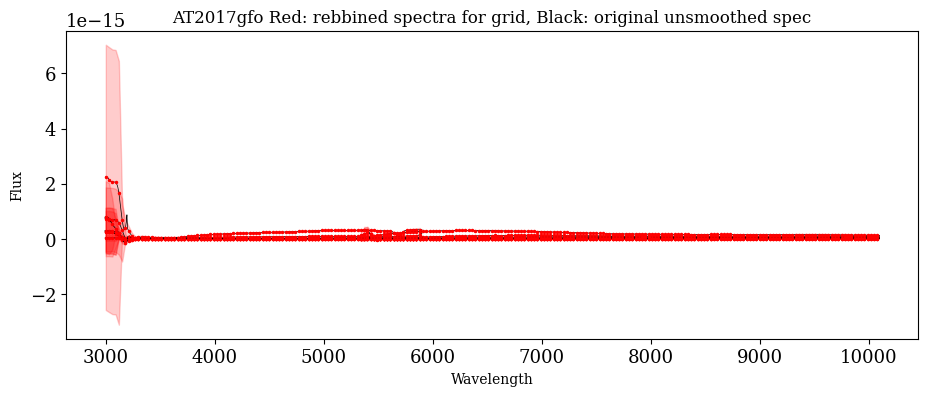

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_77465/939832204.py:278: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  else: grid_notext.loc[UVwls][phot4ext['mjd']] = phot4ext['phot'][ind]
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c00

 !!!! Skipping band Bessell_I — no valid data.
 !!!! Skipping band Bessell_U — no valid data.
  ➤ mjd_filt: [57982.72 57982.77 57982.82 57982.87 57982.92 57982.97 57983.02 57983.07
 57983.12 57983.17 57983.22 57983.27 57983.32 57983.37 57983.42 57983.47
 57983.52 57983.57 57983.62 57983.67 57983.72 57983.77 57983.82 57983.87
 57983.92 57983.97 57984.02 57984.07 57984.12 57984.17 57984.22 57984.27
 57984.32 57984.37 57984.42 57984.47 57984.52 57984.57 57984.62 57984.67
 57984.72 57984.77 57984.82 57984.87 57984.92 57984.97 57985.02 57985.07
 57985.12 57985.17 57985.22 57985.27 57985.32 57985.37 57985.42 57985.47
 57985.52 57985.57 57985.62 57985.67 57985.72 57985.77 57985.82 57985.87
 57985.92 57985.97 57986.02 57986.07 57986.12 57986.17 57986.22 57986.27
 57986.32 57986.37 57986.42 57986.47 57986.52 57986.57 57986.62 57986.67
 57986.72 57986.77 57986.82 57986.87 57986.92 57986.97 57987.02 57987.07
 57987.12 57987.17 57987.22 57987.27 57987.32 57987.37 57987.42 57987.47
 57987.52 57987.

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_77465/939832204.py:331: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grid_notext[mjds_extention[m]] = np.full(len(grid_notext.index), np.nan)
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_77465/939832204.py:332: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grid_notext_err[mjds_extention[m]] = np.full(len(grid_notext_err.index), np.nan)
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_77465/939832204.py:331: PerformanceWarning: DataFrame is highly

  ➤ mjd_filt: [57982.62 57982.67 57982.72 57982.77 57982.82 57982.87 57982.92 57982.97
 57983.02 57983.07 57983.12 57983.17 57983.22 57983.27 57983.32 57983.37
 57983.42 57983.47 57983.52 57983.57 57983.62 57983.67 57983.72 57983.77
 57983.82 57983.87 57983.92 57983.97 57984.02 57984.07 57984.12 57984.17
 57984.22 57984.27 57984.32 57984.37 57984.42 57984.47 57984.52 57984.57
 57984.62 57984.67 57984.72 57984.77 57984.82 57984.87 57984.92 57984.97
 57985.02 57985.07 57985.12 57985.17 57985.22 57985.27 57985.32 57985.37
 57985.42 57985.47 57985.52 57985.57 57985.62 57985.67 57985.72 57985.77
 57985.82 57985.87 57985.92 57985.97 57986.02 57986.07 57986.12 57986.17
 57986.22 57986.27 57986.32 57986.37 57986.42 57986.47 57986.52 57986.57
 57986.62 57986.67 57986.72 57986.77 57986.82 57986.87 57986.92 57986.97
 57987.02 57987.07 57987.12 57987.17 57987.22 57987.27 57987.32 57987.37
 57987.42 57987.47 57987.52 57987.57 57987.62 57987.67 57987.72 57987.77
 57987.82 57987.87 57987.92 57987.97 

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_77465/939832204.py:352: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grid_notext_err[mjds_grid[m]].loc[self.lam_eff(band)] = LCerr_val[m]
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c000

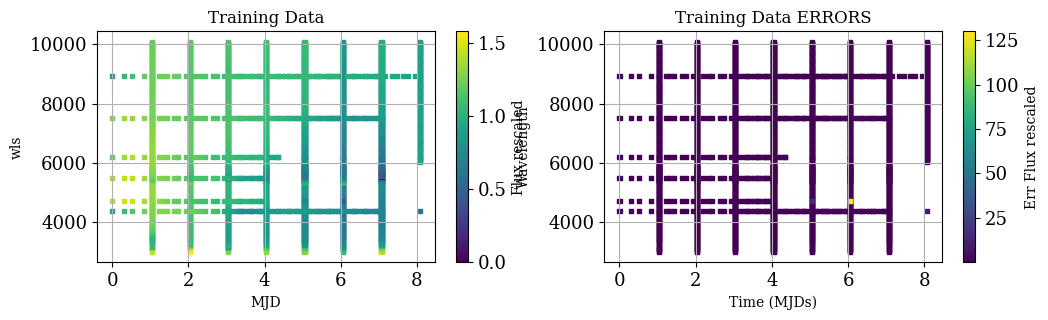

Loaded prior grid. Any NaN in color_prior: False
color_prior min/max: 0.05123 1.32729
reshaped_color_prior shape: (900, 200)
reshaped_color_prior min/max: 0.05123 1.32729
original_fit.MJD-peak min/max: -0.5000000000291038 3.8500000002240995
np.unique(phase_prior) min/max: 0.0 199.0
Vflux_phase shape: (200,)
Vflux_phase min/max: 9.649010323286543e-18 7.344387178695101e-16
Any <= 0 in Vflux_phase: False
flux_prior shape: (900, 200)
Any <= 0 in flux_prior: False
flux_prior min/max: 4.943187988619696e-19 8.41101252865699e-16
Any NaN in flux_prior_transform: False
Any Inf in flux_prior_transform: False
flux_prior_transform min/max: 0.47599107438993293 1.4518154044835632


In [21]:
# try for KN:
kernel_wls_scale = 0.05
kernel_time_scale = 0.3

## Set your prior
PRIOR_file = '/prior_SE.txt'

snname='AT2017gfo'

## First initialize the class FullMangledSeries_Class
spec_class = FullMangledSeries_Class(snname=snname, mode='extrapolate_spectra',
                                     DELTA=30., verbose=False)
# Load all the mangled spectra
raw_numbers, raw_numbers_err, off_xa, off_ya , grid_ext_columns = GP2dim.prepare_grid(snname, spec_class, )

# Trasform data to LOG, then rescale them to force them to be between 0,1 
# Then reshape the grid to feed the 2dGP
y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm = GP2dim.transform2LOG_reshape(spec_class, 
                                                                                          raw_numbers, 
                                                                                          raw_numbers_err, 
                                                                                          off_xa, off_ya)

# Make some useful plots that helps to check the data you are using to interpolate the surface
# These are saved in OUTPUT_DIR/SNname/TwoDextended_spectra
GP2dim.make_plots(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm)

# Set the prior
Xprior, yprior = GP2dim.setPRIOR(spec_class, PRIOR_file=PRIOR_file, PRIOR_folder=PRIORs_PATH)

In [22]:
print("Any NaN in yprior:", np.any(np.isnan(yprior)))
print("Any Inf in yprior:", np.any(~np.isfinite(yprior)))
print("yprior min/max:", np.nanmin(yprior), np.nanmax(yprior))

Any NaN in yprior: False
Any Inf in yprior: False
yprior min/max: 0.47599107438993293 1.4518154044835632


In [23]:
print("Any NaN in Xprior:", np.any(np.isnan(Xprior)))
print("Any Inf in Xprior:", np.any(~np.isfinite(Xprior)))
print("Xprior min/max:", np.nanmin(Xprior, axis=0), np.nanmax(Xprior, axis=0))

Any NaN in Xprior: False
Any Inf in Xprior: False
Xprior min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]


t shape: (2257, 2)
t contents: [[0.39861562 0.        ]
 [0.42887297 0.        ]
 [0.49899023 0.        ]
 ...
 [0.91090909 1.        ]
 [0.91363636 1.        ]
 [0.91636364 1.        ]]
points_eval min/max: [0.27272727 0.        ] [0.91636364 1.        ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False
t shape: (2007, 2)
t contents: [[ 0.14545455 -0.03858222]
 [ 0.14545455 -0.02572148]
 [ 0.14545455 -0.01286074]
 ...
 [ 0.93818182 -0.03858222]
 [ 0.93818182 -0.02572148]
 [ 0.93818182 -0.01286074]]
points_eval min/max: [ 0.14545455 -0.03858222] [ 0.93818182 -0.01286074]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


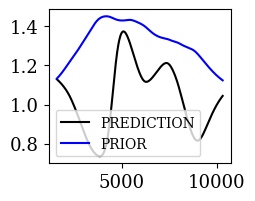

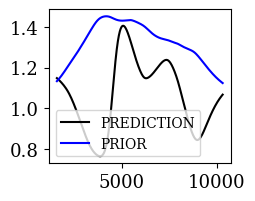

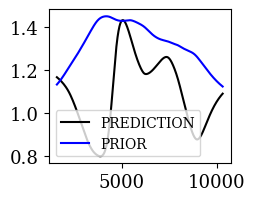

t shape: (2007, 2)
t contents: [[0.14545455 0.        ]
 [0.14545455 0.01286074]
 [0.14545455 0.02572148]
 ...
 [0.93818182 0.        ]
 [0.93818182 0.01286074]
 [0.93818182 0.02572148]]
points_eval min/max: [0.14545455 0.        ] [0.93818182 0.02572148]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


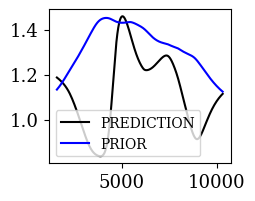

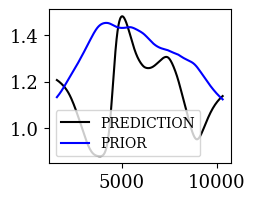

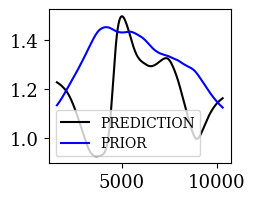

t shape: (2007, 2)
t contents: [[0.14545455 0.03858222]
 [0.14545455 0.05144296]
 [0.14545455 0.0643037 ]
 ...
 [0.93818182 0.03858222]
 [0.93818182 0.05144296]
 [0.93818182 0.0643037 ]]
points_eval min/max: [0.14545455 0.03858222] [0.93818182 0.0643037 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


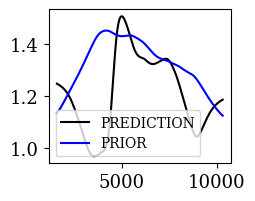

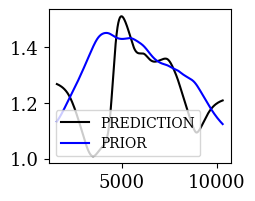

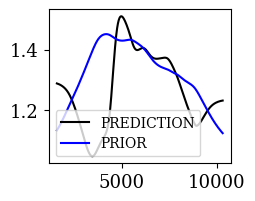

t shape: (2007, 2)
t contents: [[0.14545455 0.0646976 ]
 [0.14545455 0.07716444]
 [0.14545455 0.09002518]
 ...
 [0.93818182 0.0646976 ]
 [0.93818182 0.07716444]
 [0.93818182 0.09002518]]
points_eval min/max: [0.14545455 0.0646976 ] [0.93818182 0.09002518]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


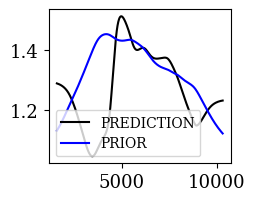

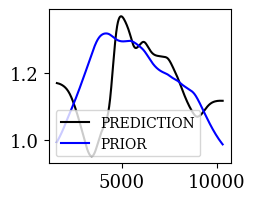

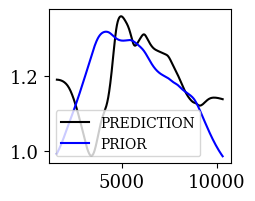

t shape: (2007, 2)
t contents: [[0.14545455 0.10288592]
 [0.14545455 0.11574666]
 [0.14545455 0.1286074 ]
 ...
 [0.93818182 0.10288592]
 [0.93818182 0.11574666]
 [0.93818182 0.1286074 ]]
points_eval min/max: [0.14545455 0.10288592] [0.93818182 0.1286074 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


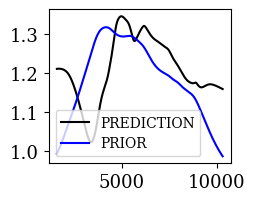

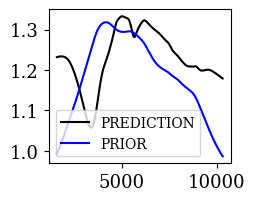

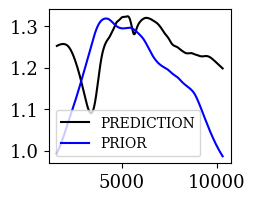

t shape: (2007, 2)
t contents: [[0.14545455 0.12860752]
 [0.14545455 0.14100099]
 [0.14545455 0.14100109]
 ...
 [0.93818182 0.12860752]
 [0.93818182 0.14100099]
 [0.93818182 0.14100109]]
points_eval min/max: [0.14545455 0.12860752] [0.93818182 0.14100109]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


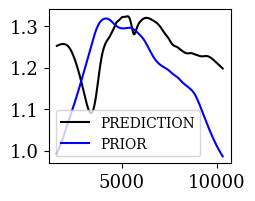

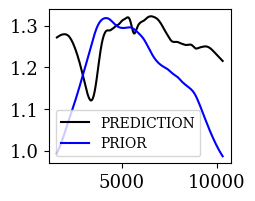

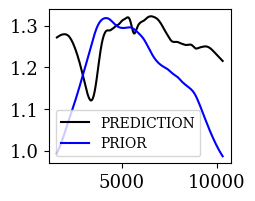

t shape: (2007, 2)
t contents: [[0.14545455 0.15339458]
 [0.14545455 0.15339465]
 [0.14545455 0.16578817]
 ...
 [0.93818182 0.15339458]
 [0.93818182 0.15339465]
 [0.93818182 0.16578817]]
points_eval min/max: [0.14545455 0.15339458] [0.93818182 0.16578817]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


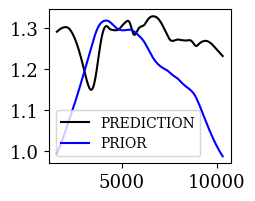

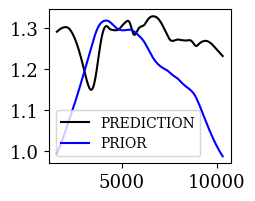

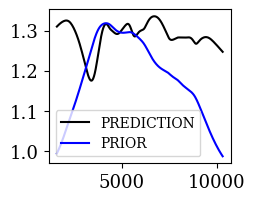

t shape: (2007, 2)
t contents: [[0.14545455 0.16578822]
 [0.14545455 0.16797742]
 [0.14545455 0.17818176]
 ...
 [0.93818182 0.16578822]
 [0.93818182 0.16797742]
 [0.93818182 0.17818176]]
points_eval min/max: [0.14545455 0.16578822] [0.93818182 0.17818176]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


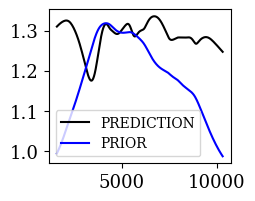

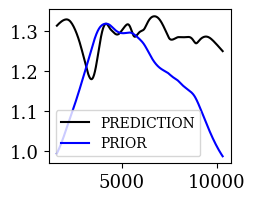

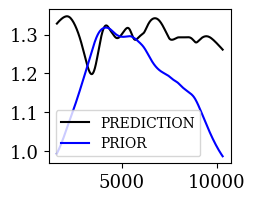

t shape: (2007, 2)
t contents: [[0.14545455 0.17818178]
 [0.14545455 0.19057535]
 [0.14545455 0.20296892]
 ...
 [0.93818182 0.17818178]
 [0.93818182 0.19057535]
 [0.93818182 0.20296892]]
points_eval min/max: [0.14545455 0.17818178] [0.93818182 0.20296892]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


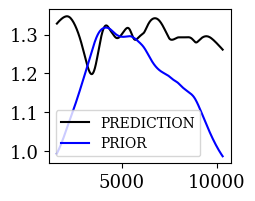

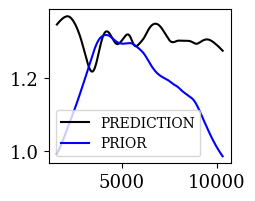

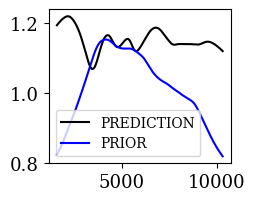

t shape: (2007, 2)
t contents: [[0.14545455 0.20296894]
 [0.14545455 0.21536248]
 [0.14545455 0.21536253]
 ...
 [0.93818182 0.20296894]
 [0.93818182 0.21536248]
 [0.93818182 0.21536253]]
points_eval min/max: [0.14545455 0.20296894] [0.93818182 0.21536253]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


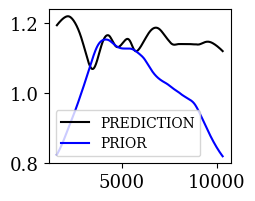

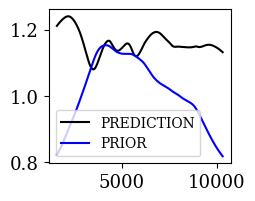

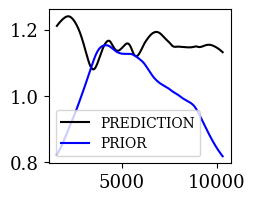

t shape: (2007, 2)
t contents: [[0.14545455 0.22775605]
 [0.14545455 0.22775612]
 [0.14545455 0.24014961]
 ...
 [0.93818182 0.22775605]
 [0.93818182 0.22775612]
 [0.93818182 0.24014961]]
points_eval min/max: [0.14545455 0.22775605] [0.93818182 0.24014961]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


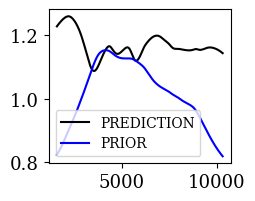

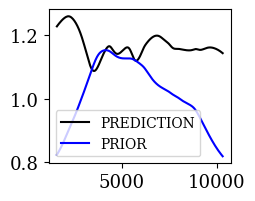

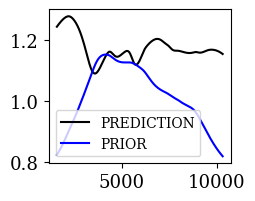

t shape: (2007, 2)
t contents: [[0.14545455 0.24014971]
 [0.14545455 0.25254318]
 [0.14545455 0.2525433 ]
 ...
 [0.93818182 0.24014971]
 [0.93818182 0.25254318]
 [0.93818182 0.2525433 ]]
points_eval min/max: [0.14545455 0.24014971] [0.93818182 0.2525433 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


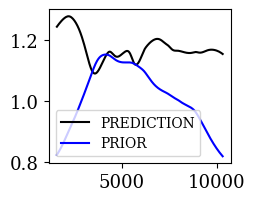

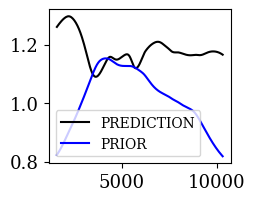

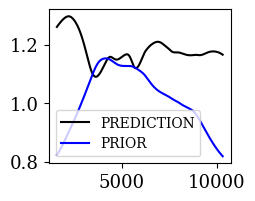

t shape: (2007, 2)
t contents: [[0.14545455 0.26500182]
 [0.14545455 0.26500195]
 [0.14545455 0.27125723]
 ...
 [0.93818182 0.26500182]
 [0.93818182 0.26500195]
 [0.93818182 0.27125723]]
points_eval min/max: [0.14545455 0.26500182] [0.93818182 0.27125723]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


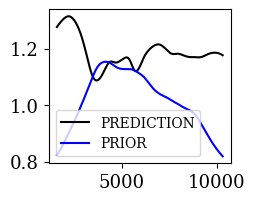

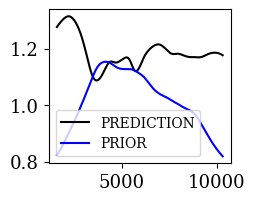

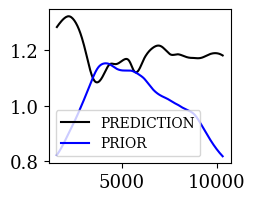

t shape: (2007, 2)
t contents: [[0.14545455 0.27746047]
 [0.14545455 0.27746059]
 [0.14545455 0.28991911]
 ...
 [0.93818182 0.27746047]
 [0.93818182 0.27746059]
 [0.93818182 0.28991911]]
points_eval min/max: [0.14545455 0.27746047] [0.93818182 0.28991911]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


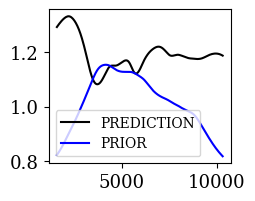

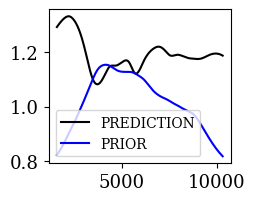

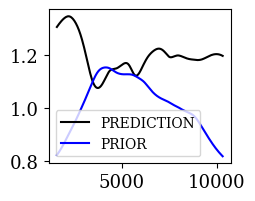

t shape: (2007, 2)
t contents: [[0.14545455 0.28991924]
 [0.14545455 0.30237776]
 [0.14545455 0.30237788]
 ...
 [0.93818182 0.28991924]
 [0.93818182 0.30237776]
 [0.93818182 0.30237788]]
points_eval min/max: [0.14545455 0.28991924] [0.93818182 0.30237788]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


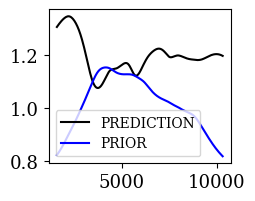

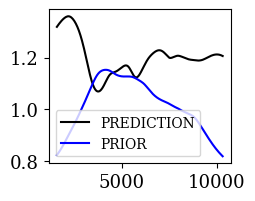

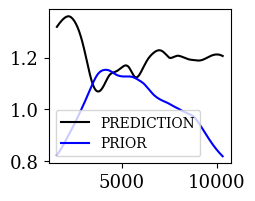

t shape: (2007, 2)
t contents: [[0.14545455 0.3148364 ]
 [0.14545455 0.31483652]
 [0.14545455 0.32729505]
 ...
 [0.93818182 0.3148364 ]
 [0.93818182 0.31483652]
 [0.93818182 0.32729505]]
points_eval min/max: [0.14545455 0.3148364 ] [0.93818182 0.32729505]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


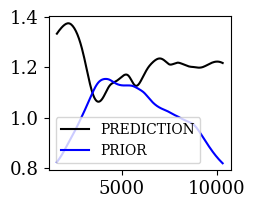

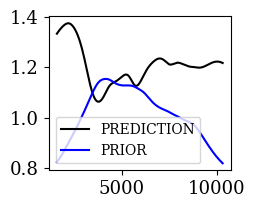

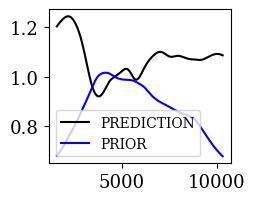

t shape: (2007, 2)
t contents: [[0.14545455 0.32729517]
 [0.14545455 0.33975369]
 [0.14545455 0.33975381]
 ...
 [0.93818182 0.32729517]
 [0.93818182 0.33975369]
 [0.93818182 0.33975381]]
points_eval min/max: [0.14545455 0.32729517] [0.93818182 0.33975381]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


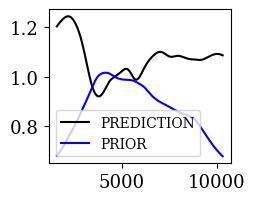

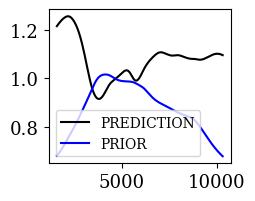

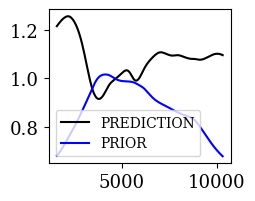

t shape: (2007, 2)
t contents: [[0.14545455 0.35221233]
 [0.14545455 0.35221246]
 [0.14545455 0.36467098]
 ...
 [0.93818182 0.35221233]
 [0.93818182 0.35221246]
 [0.93818182 0.36467098]]
points_eval min/max: [0.14545455 0.35221233] [0.93818182 0.36467098]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


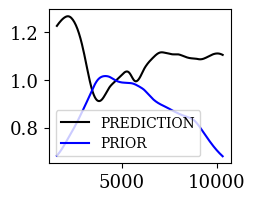

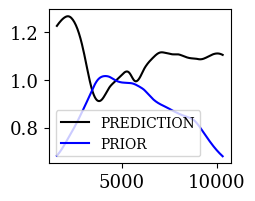

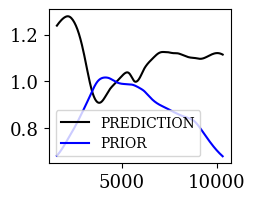

t shape: (2007, 2)
t contents: [[0.14545455 0.3646711 ]
 [0.14545455 0.37453705]
 [0.14545455 0.37709864]
 ...
 [0.93818182 0.3646711 ]
 [0.93818182 0.37453705]
 [0.93818182 0.37709864]]
points_eval min/max: [0.14545455 0.3646711 ] [0.93818182 0.37709864]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


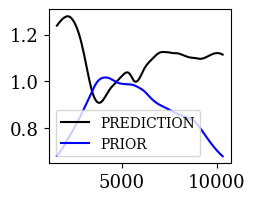

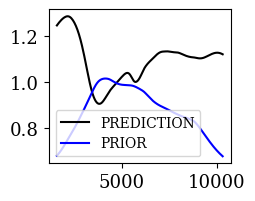

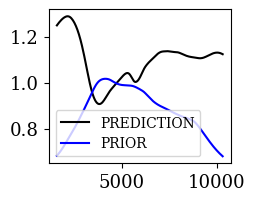

t shape: (2007, 2)
t contents: [[0.14545455 0.37709876]
 [0.14545455 0.37712962]
 [0.14545455 0.37712975]
 ...
 [0.93818182 0.37709876]
 [0.93818182 0.37712962]
 [0.93818182 0.37712975]]
points_eval min/max: [0.14545455 0.37709876] [0.93818182 0.37712975]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


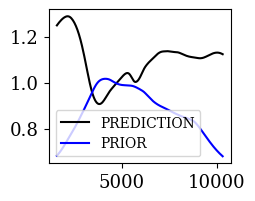

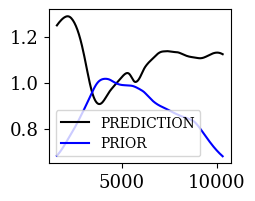

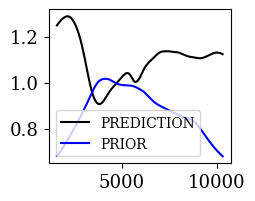

t shape: (2007, 2)
t contents: [[0.14545455 0.38949233]
 [0.14545455 0.38955667]
 [0.14545455 0.38958827]
 ...
 [0.93818182 0.38949233]
 [0.93818182 0.38955667]
 [0.93818182 0.38958827]]
points_eval min/max: [0.14545455 0.38949233] [0.93818182 0.38958827]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


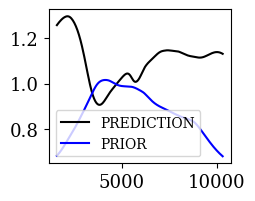

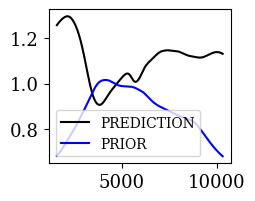

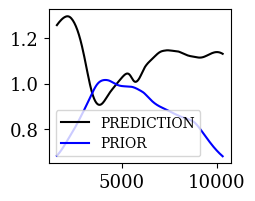

t shape: (2007, 2)
t contents: [[0.14545455 0.38958839]
 [0.14545455 0.40188589]
 [0.14545455 0.40201469]
 ...
 [0.93818182 0.38958839]
 [0.93818182 0.40188589]
 [0.93818182 0.40201469]]
points_eval min/max: [0.14545455 0.38958839] [0.93818182 0.40201469]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


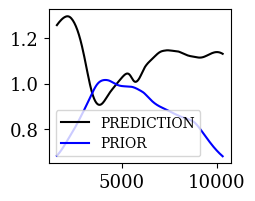

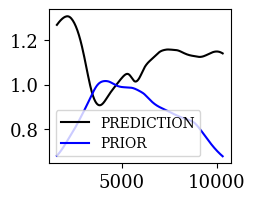

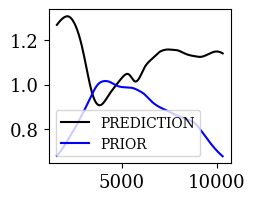

t shape: (2007, 2)
t contents: [[0.14545455 0.40204691]
 [0.14545455 0.40204704]
 [0.14545455 0.41427946]
 ...
 [0.93818182 0.40204691]
 [0.93818182 0.40204704]
 [0.93818182 0.41427946]]
points_eval min/max: [0.14545455 0.40204691] [0.93818182 0.41427946]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


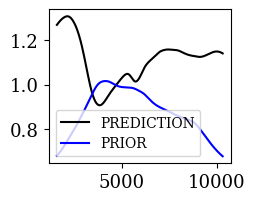

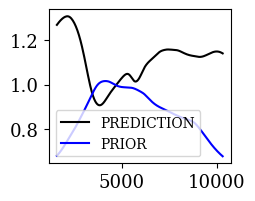

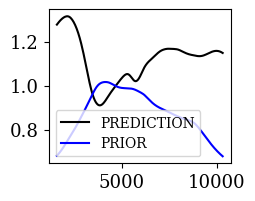

t shape: (2007, 2)
t contents: [[0.14545455 0.41447272]
 [0.14545455 0.41450556]
 [0.14545455 0.41450568]
 ...
 [0.93818182 0.41447272]
 [0.93818182 0.41450556]
 [0.93818182 0.41450568]]
points_eval min/max: [0.14545455 0.41447272] [0.93818182 0.41450568]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


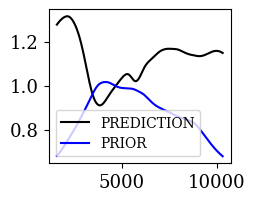

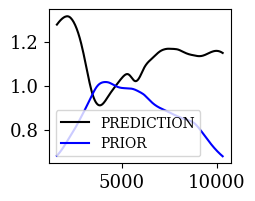

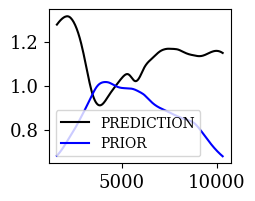

t shape: (2007, 2)
t contents: [[0.14545455 0.42667303]
 [0.14545455 0.42693075]
 [0.14545455 0.4269642 ]
 ...
 [0.93818182 0.42667303]
 [0.93818182 0.42693075]
 [0.93818182 0.4269642 ]]
points_eval min/max: [0.14545455 0.42667303] [0.93818182 0.4269642 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


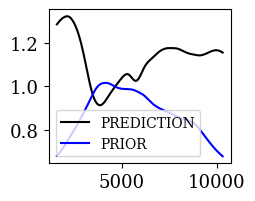

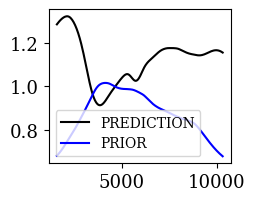

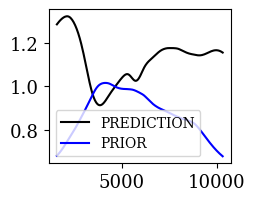

t shape: (2007, 2)
t contents: [[0.14545455 0.42696432]
 [0.14545455 0.43906659]
 [0.14545455 0.43938878]
 ...
 [0.93818182 0.42696432]
 [0.93818182 0.43906659]
 [0.93818182 0.43938878]]
points_eval min/max: [0.14545455 0.42696432] [0.93818182 0.43938878]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


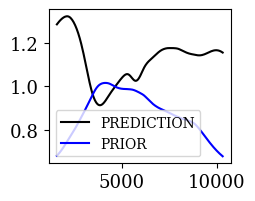

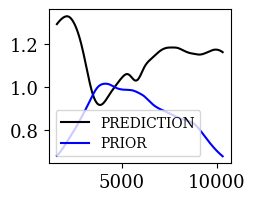

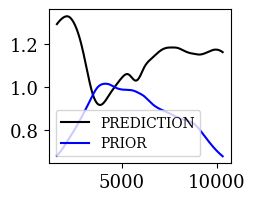

t shape: (2007, 2)
t contents: [[0.14545455 0.43942285]
 [0.14545455 0.43942297]
 [0.14545455 0.45146016]
 ...
 [0.93818182 0.43942285]
 [0.93818182 0.43942297]
 [0.93818182 0.45146016]]
points_eval min/max: [0.14545455 0.43942285] [0.93818182 0.45146016]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


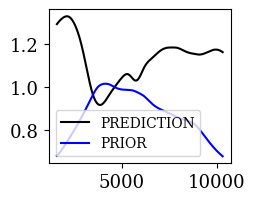

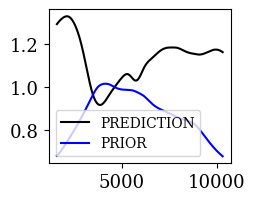

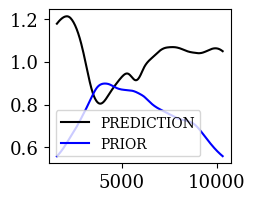

t shape: (2007, 2)
t contents: [[0.14545455 0.4518468 ]
 [0.14545455 0.45188149]
 [0.14545455 0.45188161]
 ...
 [0.93818182 0.4518468 ]
 [0.93818182 0.45188149]
 [0.93818182 0.45188161]]
points_eval min/max: [0.14545455 0.4518468 ] [0.93818182 0.45188161]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


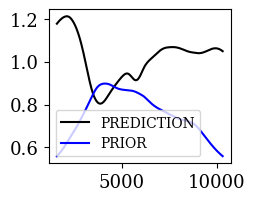

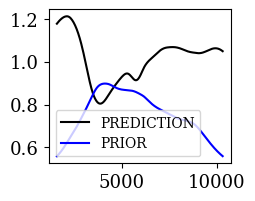

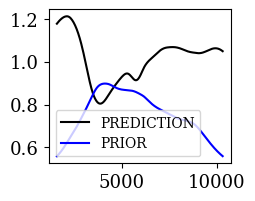

t shape: (2007, 2)
t contents: [[0.14545455 0.46385372]
 [0.14545455 0.46430483]
 [0.14545455 0.46434013]
 ...
 [0.93818182 0.46385372]
 [0.93818182 0.46430483]
 [0.93818182 0.46434013]]
points_eval min/max: [0.14545455 0.46385372] [0.93818182 0.46434013]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


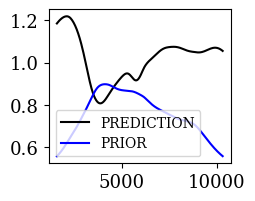

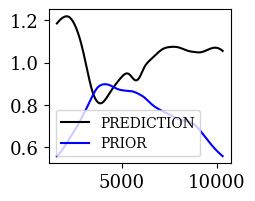

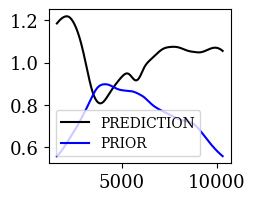

t shape: (2007, 2)
t contents: [[0.14545455 0.46434026]
 [0.14545455 0.47624729]
 [0.14545455 0.47676286]
 ...
 [0.93818182 0.46434026]
 [0.93818182 0.47624729]
 [0.93818182 0.47676286]]
points_eval min/max: [0.14545455 0.46434026] [0.93818182 0.47676286]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


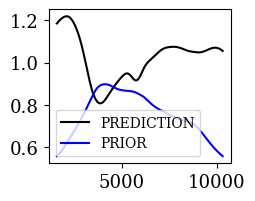

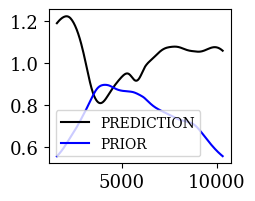

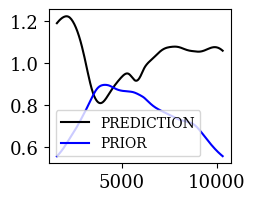

t shape: (2007, 2)
t contents: [[0.14545455 0.47679878]
 [0.14545455 0.4767989 ]
 [0.14545455 0.47781687]
 ...
 [0.93818182 0.47679878]
 [0.93818182 0.4767989 ]
 [0.93818182 0.47781687]]
points_eval min/max: [0.14545455 0.47679878] [0.93818182 0.47781687]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


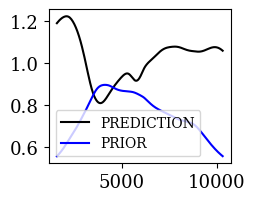

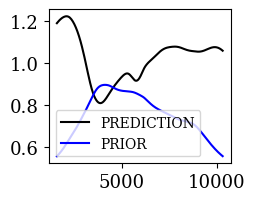

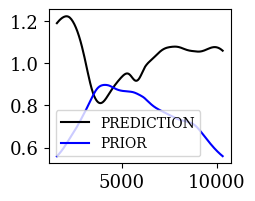

t shape: (2007, 2)
t contents: [[0.14545455 0.48864085]
 [0.14545455 0.48922088]
 [0.14545455 0.48925742]
 ...
 [0.93818182 0.48864085]
 [0.93818182 0.48922088]
 [0.93818182 0.48925742]]
points_eval min/max: [0.14545455 0.48864085] [0.93818182 0.48925742]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


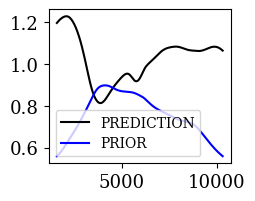

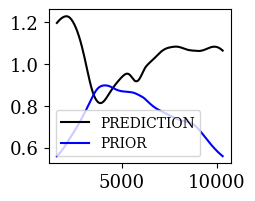

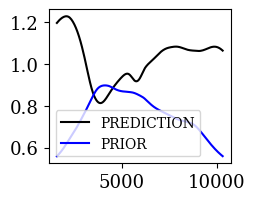

t shape: (2007, 2)
t contents: [[0.14545455 0.48925755]
 [0.14545455 0.50103442]
 [0.14545455 0.50103454]
 ...
 [0.93818182 0.48925755]
 [0.93818182 0.50103442]
 [0.93818182 0.50103454]]
points_eval min/max: [0.14545455 0.48925755] [0.93818182 0.50103454]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


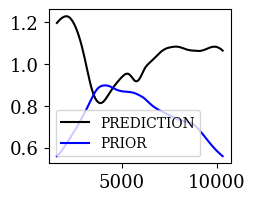

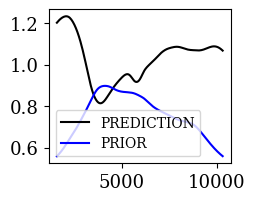

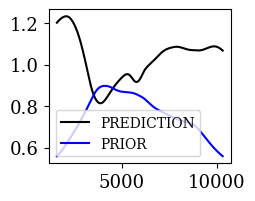

t shape: (2007, 2)
t contents: [[0.14545455 0.50167891]
 [0.14545455 0.50171607]
 [0.14545455 0.50171619]
 ...
 [0.93818182 0.50167891]
 [0.93818182 0.50171607]
 [0.93818182 0.50171619]]
points_eval min/max: [0.14545455 0.50167891] [0.93818182 0.50171619]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


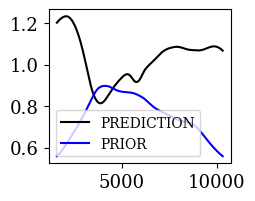

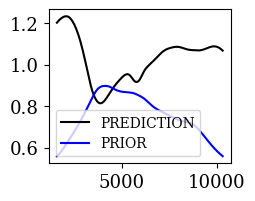

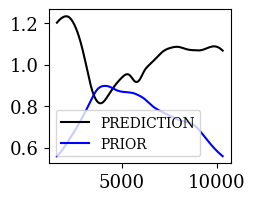

t shape: (2007, 2)
t contents: [[0.14545455 0.51341572]
 [0.14545455 0.51413694]
 [0.14545455 0.51417471]
 ...
 [0.93818182 0.51341572]
 [0.93818182 0.51413694]
 [0.93818182 0.51417471]]
points_eval min/max: [0.14545455 0.51341572] [0.93818182 0.51417471]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


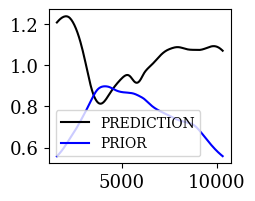

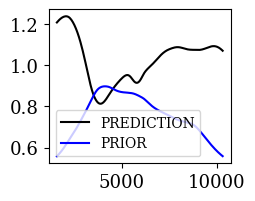

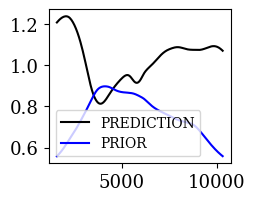

t shape: (2007, 2)
t contents: [[0.14545455 0.51417484]
 [0.14545455 0.52579689]
 [0.14545455 0.52659497]
 ...
 [0.93818182 0.51417484]
 [0.93818182 0.52579689]
 [0.93818182 0.52659497]]
points_eval min/max: [0.14545455 0.51417484] [0.93818182 0.52659497]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


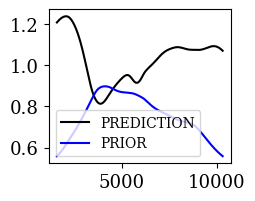

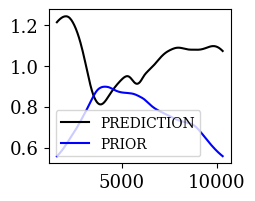

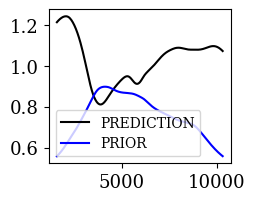

t shape: (2007, 2)
t contents: [[0.14545455 0.52663336]
 [0.14545455 0.52663348]
 [0.14545455 0.53817807]
 ...
 [0.93818182 0.52663336]
 [0.93818182 0.52663348]
 [0.93818182 0.53817807]]
points_eval min/max: [0.14545455 0.52663336] [0.93818182 0.53817807]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


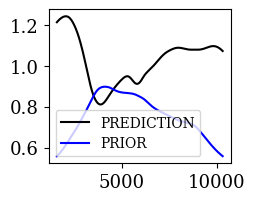

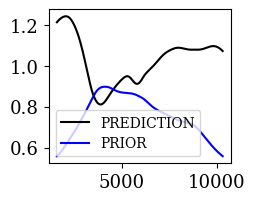

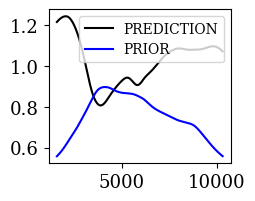

t shape: (2007, 2)
t contents: [[0.14545455 0.53905299]
 [0.14545455 0.539092  ]
 [0.14545455 0.53909212]
 ...
 [0.93818182 0.53905299]
 [0.93818182 0.539092  ]
 [0.93818182 0.53909212]]
points_eval min/max: [0.14545455 0.53905299] [0.93818182 0.53909212]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


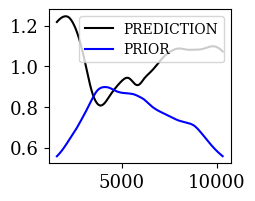

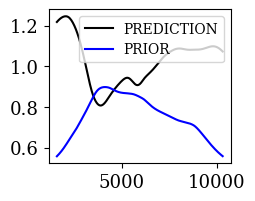

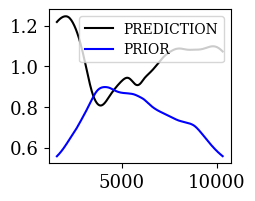

t shape: (2007, 2)
t contents: [[0.14545455 0.55055925]
 [0.14545455 0.55151102]
 [0.14545455 0.55155064]
 ...
 [0.93818182 0.55055925]
 [0.93818182 0.55151102]
 [0.93818182 0.55155064]]
points_eval min/max: [0.14545455 0.55055925] [0.93818182 0.55155064]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


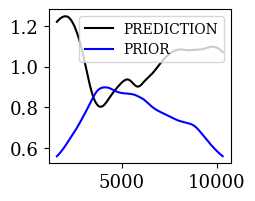

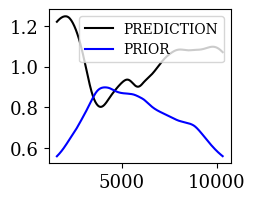

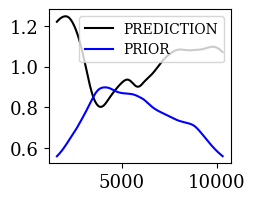

t shape: (2007, 2)
t contents: [[0.14545455 0.55155077]
 [0.14545455 0.56294042]
 [0.14545455 0.56396905]
 ...
 [0.93818182 0.55155077]
 [0.93818182 0.56294042]
 [0.93818182 0.56396905]]
points_eval min/max: [0.14545455 0.55155077] [0.93818182 0.56396905]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


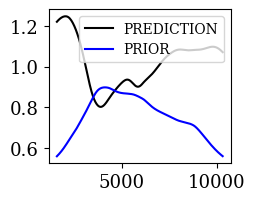

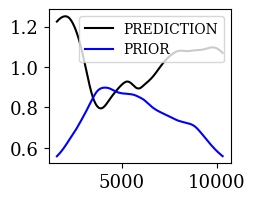

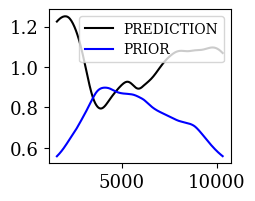

t shape: (2007, 2)
t contents: [[0.14545455 0.56400929]
 [0.14545455 0.56400941]
 [0.14545455 0.5753216 ]
 ...
 [0.93818182 0.56400929]
 [0.93818182 0.56400941]
 [0.93818182 0.5753216 ]]
points_eval min/max: [0.14545455 0.56400929] [0.93818182 0.5753216 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


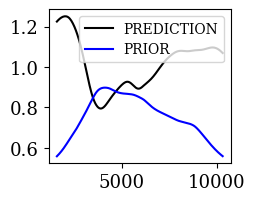

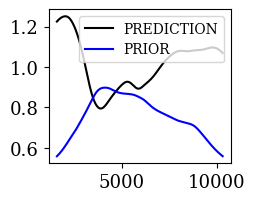

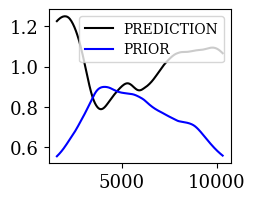

t shape: (2007, 2)
t contents: [[0.14545455 0.57642707]
 [0.14545455 0.57646793]
 [0.14545455 0.57646806]
 ...
 [0.93818182 0.57642707]
 [0.93818182 0.57646793]
 [0.93818182 0.57646806]]
points_eval min/max: [0.14545455 0.57642707] [0.93818182 0.57646806]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


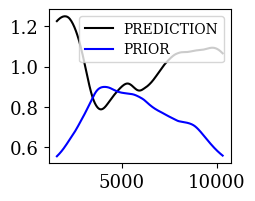

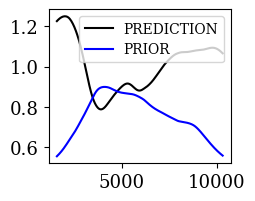

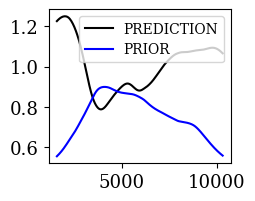

t shape: (2007, 2)
t contents: [[0.14545455 0.58109669]
 [0.14545455 0.58770277]
 [0.14545455 0.5888851 ]
 ...
 [0.93818182 0.58109669]
 [0.93818182 0.58770277]
 [0.93818182 0.5888851 ]]
points_eval min/max: [0.14545455 0.58109669] [0.93818182 0.5888851 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


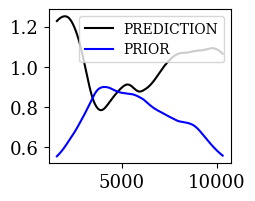

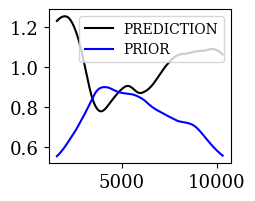

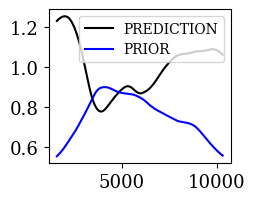

t shape: (2007, 2)
t contents: [[0.14545455 0.58892658]
 [0.14545455 0.5889267 ]
 [0.14545455 0.60008395]
 ...
 [0.93818182 0.58892658]
 [0.93818182 0.5889267 ]
 [0.93818182 0.60008395]]
points_eval min/max: [0.14545455 0.58892658] [0.93818182 0.60008395]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


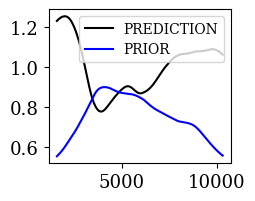

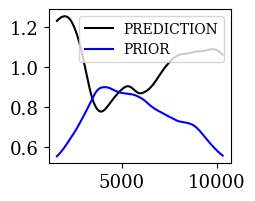

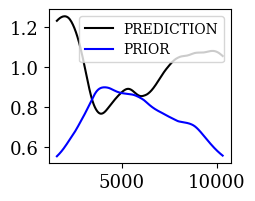

t shape: (2007, 2)
t contents: [[0.14545455 0.60134313]
 [0.14545455 0.60138522]
 [0.14545455 0.60138535]
 ...
 [0.93818182 0.60134313]
 [0.93818182 0.60138522]
 [0.93818182 0.60138535]]
points_eval min/max: [0.14545455 0.60134313] [0.93818182 0.60138535]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


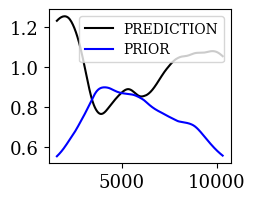

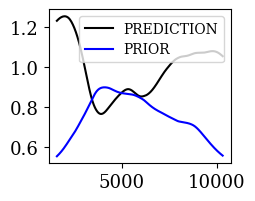

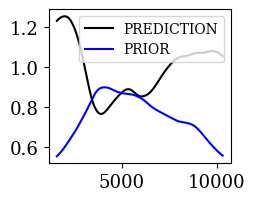

t shape: (2007, 2)
t contents: [[0.14545455 0.61246512]
 [0.14545455 0.61380116]
 [0.14545455 0.61384387]
 ...
 [0.93818182 0.61246512]
 [0.93818182 0.61380116]
 [0.93818182 0.61384387]]
points_eval min/max: [0.14545455 0.61246512] [0.93818182 0.61384387]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


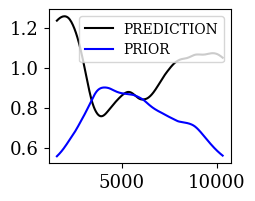

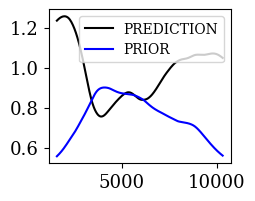

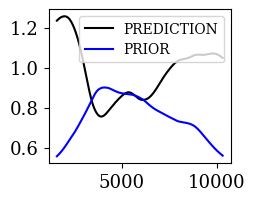

t shape: (2007, 2)
t contents: [[0.14545455 0.61384399]
 [0.14545455 0.6248463 ]
 [0.14545455 0.62571382]
 ...
 [0.93818182 0.61384399]
 [0.93818182 0.6248463 ]
 [0.93818182 0.62571382]]
points_eval min/max: [0.14545455 0.61384399] [0.93818182 0.62571382]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


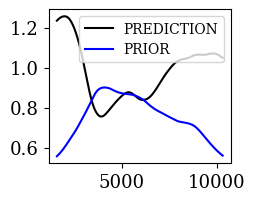

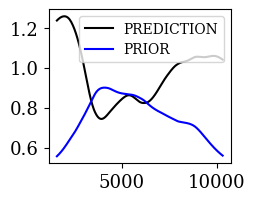

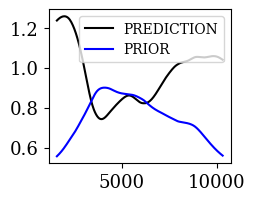

t shape: (2007, 2)
t contents: [[0.14545455 0.62571394]
 [0.14545455 0.62625918]
 [0.14545455 0.62630251]
 ...
 [0.93818182 0.62571394]
 [0.93818182 0.62625918]
 [0.93818182 0.62630251]]
points_eval min/max: [0.14545455 0.62571394] [0.93818182 0.62630251]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


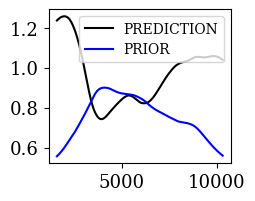

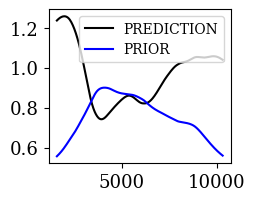

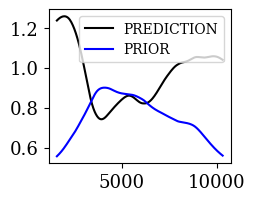

t shape: (2007, 2)
t contents: [[0.14545455 0.62630264]
 [0.14545455 0.63722747]
 [0.14545455 0.63823133]
 ...
 [0.93818182 0.62630264]
 [0.93818182 0.63722747]
 [0.93818182 0.63823133]]
points_eval min/max: [0.14545455 0.62630264] [0.93818182 0.63823133]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


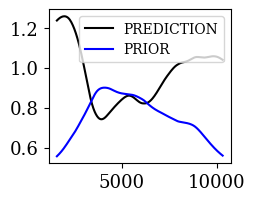

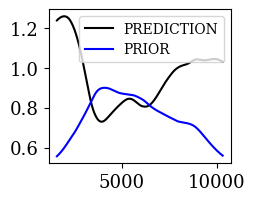

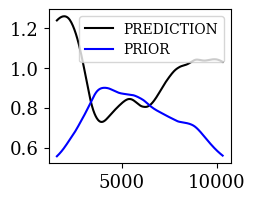

t shape: (2007, 2)
t contents: [[0.14545455 0.63871721]
 [0.14545455 0.63876116]
 [0.14545455 0.63876128]
 ...
 [0.93818182 0.63871721]
 [0.93818182 0.63876116]
 [0.93818182 0.63876128]]
points_eval min/max: [0.14545455 0.63871721] [0.93818182 0.63876128]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


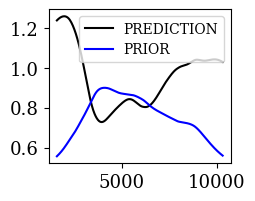

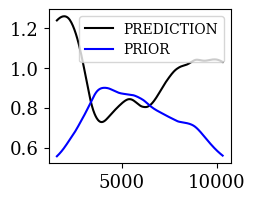

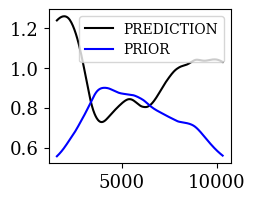

t shape: (2007, 2)
t contents: [[0.14545455 0.64960865]
 [0.14545455 0.65074884]
 [0.14545455 0.65117524]
 ...
 [0.93818182 0.64960865]
 [0.93818182 0.65074884]
 [0.93818182 0.65117524]]
points_eval min/max: [0.14545455 0.64960865] [0.93818182 0.65117524]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


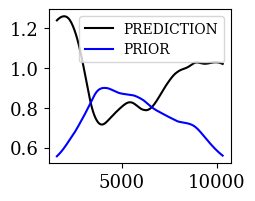

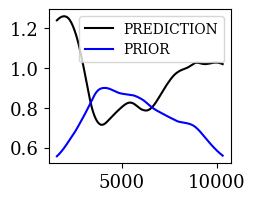

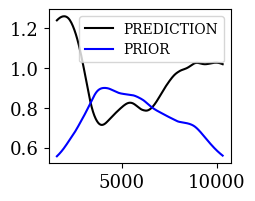

t shape: (2007, 2)
t contents: [[0.14545455 0.6512198 ]
 [0.14545455 0.65121992]
 [0.14545455 0.66198982]
 ...
 [0.93818182 0.6512198 ]
 [0.93818182 0.65121992]
 [0.93818182 0.66198982]]
points_eval min/max: [0.14545455 0.6512198 ] [0.93818182 0.66198982]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


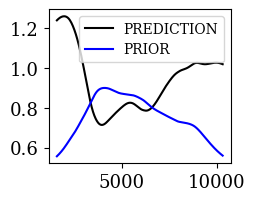

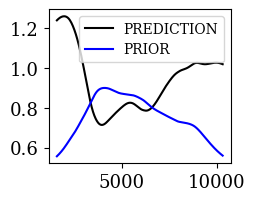

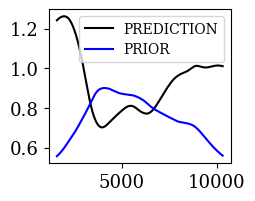

t shape: (2007, 2)
t contents: [[0.14545455 0.66326636]
 [0.14545455 0.66363327]
 [0.14545455 0.66367844]
 ...
 [0.93818182 0.66326636]
 [0.93818182 0.66363327]
 [0.93818182 0.66367844]]
points_eval min/max: [0.14545455 0.66326636] [0.93818182 0.66367844]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


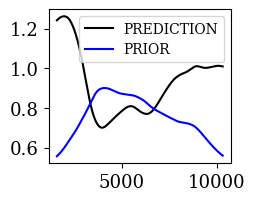

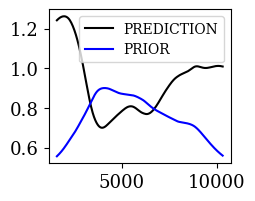

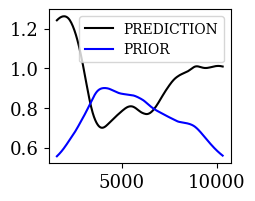

t shape: (2007, 2)
t contents: [[0.14545455 0.66367857]
 [0.14545455 0.674371  ]
 [0.14545455 0.67578387]
 ...
 [0.93818182 0.66367857]
 [0.93818182 0.674371  ]
 [0.93818182 0.67578387]]
points_eval min/max: [0.14545455 0.66367857] [0.93818182 0.67578387]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


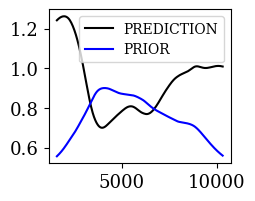

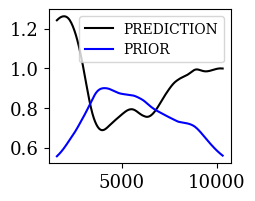

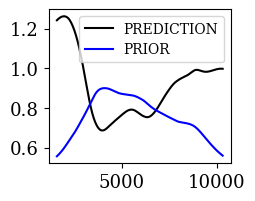

t shape: (2007, 2)
t contents: [[0.14545455 0.67609129]
 [0.14545455 0.67613709]
 [0.14545455 0.67613721]
 ...
 [0.93818182 0.67609129]
 [0.93818182 0.67613709]
 [0.93818182 0.67613721]]
points_eval min/max: [0.14545455 0.67609129] [0.93818182 0.67613721]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


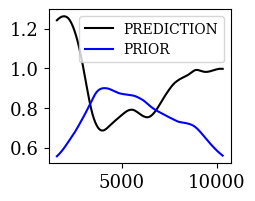

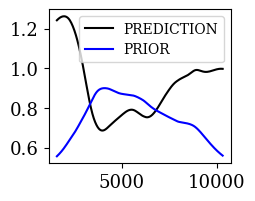

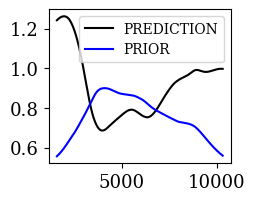

t shape: (2007, 2)
t contents: [[0.14545455 0.68675217]
 [0.14545455 0.68830139]
 [0.14545455 0.68854932]
 ...
 [0.93818182 0.68675217]
 [0.93818182 0.68830139]
 [0.93818182 0.68854932]]
points_eval min/max: [0.14545455 0.68675217] [0.93818182 0.68854932]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


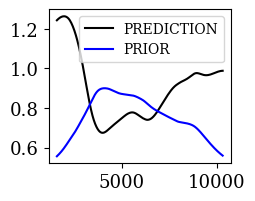

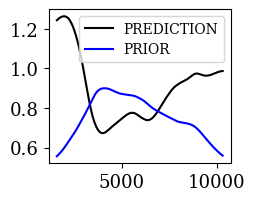

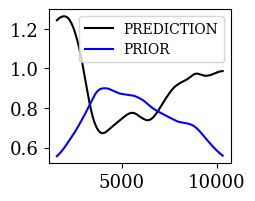

t shape: (2007, 2)
t contents: [[0.14545455 0.68859573]
 [0.14545455 0.68859586]
 [0.14545455 0.69913335]
 ...
 [0.93818182 0.68859573]
 [0.93818182 0.68859586]
 [0.93818182 0.69913335]]
points_eval min/max: [0.14545455 0.68859573] [0.93818182 0.69913335]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


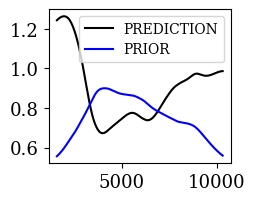

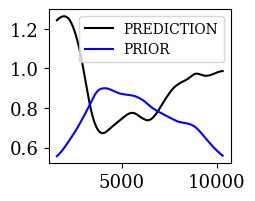

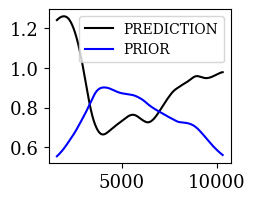

t shape: (2007, 2)
t contents: [[0.14545455 0.7008189 ]
 [0.14545455 0.70100735]
 [0.14545455 0.70105438]
 ...
 [0.93818182 0.7008189 ]
 [0.93818182 0.70100735]
 [0.93818182 0.70105438]]
points_eval min/max: [0.14545455 0.7008189 ] [0.93818182 0.70105438]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


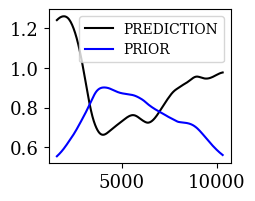

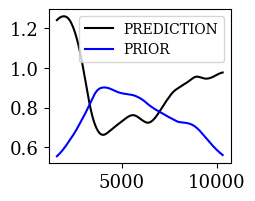

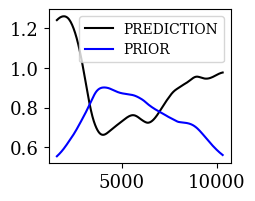

t shape: (2007, 2)
t contents: [[0.14545455 0.7010545 ]
 [0.14545455 0.71151452]
 [0.14545455 0.71333641]
 ...
 [0.93818182 0.7010545 ]
 [0.93818182 0.71151452]
 [0.93818182 0.71333641]]
points_eval min/max: [0.14545455 0.7010545 ] [0.93818182 0.71333641]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


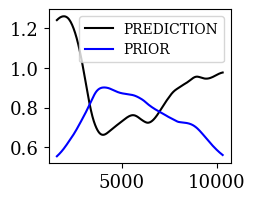

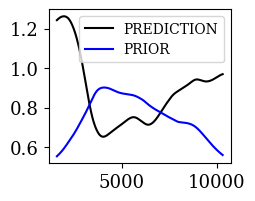

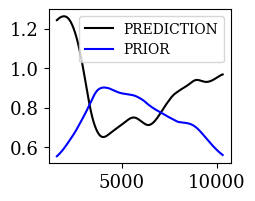

t shape: (2007, 2)
t contents: [[0.14545455 0.71346537]
 [0.14545455 0.71351302]
 [0.14545455 0.71351315]
 ...
 [0.93818182 0.71346537]
 [0.93818182 0.71351302]
 [0.93818182 0.71351315]]
points_eval min/max: [0.14545455 0.71346537] [0.93818182 0.71351315]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


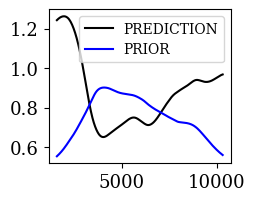

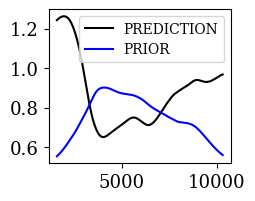

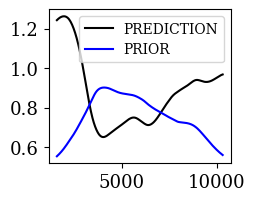

t shape: (2007, 2)
t contents: [[0.14545455 0.7238957 ]
 [0.14545455 0.72585393]
 [0.14545455 0.7259234 ]
 ...
 [0.93818182 0.7238957 ]
 [0.93818182 0.72585393]
 [0.93818182 0.7259234 ]]
points_eval min/max: [0.14545455 0.7238957 ] [0.93818182 0.7259234 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


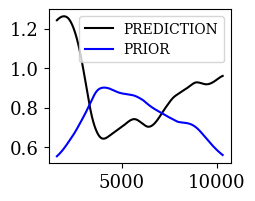

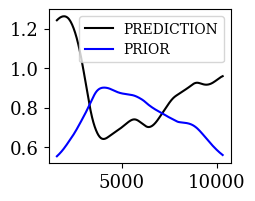

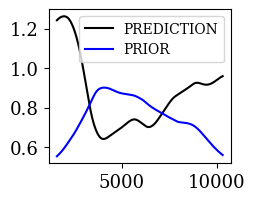

t shape: (2007, 2)
t contents: [[0.14545455 0.72597167]
 [0.14545455 0.72597179]
 [0.14545455 0.73627687]
 ...
 [0.93818182 0.72597167]
 [0.93818182 0.72597179]
 [0.93818182 0.73627687]]
points_eval min/max: [0.14545455 0.72597167] [0.93818182 0.73627687]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


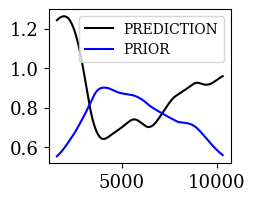

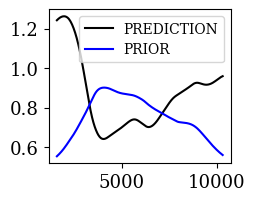

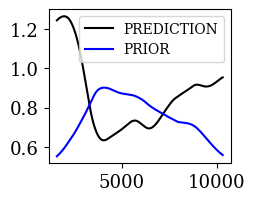

t shape: (2007, 2)
t contents: [[0.14545455 0.73837144]
 [0.14545455 0.73838143]
 [0.14545455 0.73843031]
 ...
 [0.93818182 0.73837144]
 [0.93818182 0.73838143]
 [0.93818182 0.73843031]]
points_eval min/max: [0.14545455 0.73837144] [0.93818182 0.73843031]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


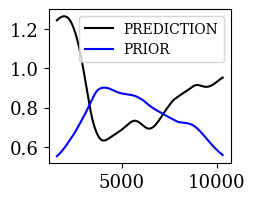

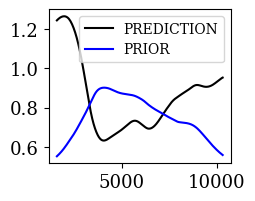

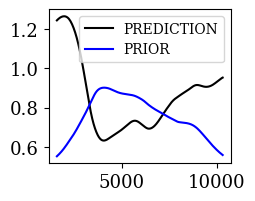

t shape: (2007, 2)
t contents: [[0.14545455 0.73843044]
 [0.14545455 0.74865805]
 [0.14545455 0.75083946]
 ...
 [0.93818182 0.73843044]
 [0.93818182 0.74865805]
 [0.93818182 0.75083946]]
points_eval min/max: [0.14545455 0.73843044] [0.93818182 0.75083946]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


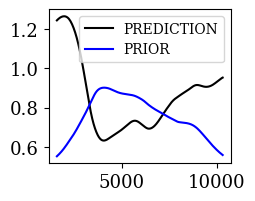

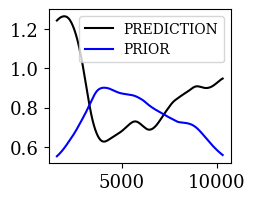

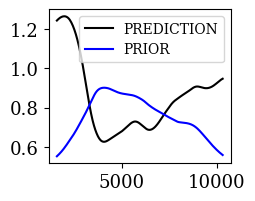

t shape: (2007, 2)
t contents: [[0.14545455 0.75088896]
 [0.14545455 0.75088908]
 [0.14545455 0.76103922]
 ...
 [0.93818182 0.75088896]
 [0.93818182 0.75088908]
 [0.93818182 0.76103922]]
points_eval min/max: [0.14545455 0.75088896] [0.93818182 0.76103922]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


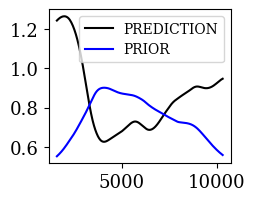

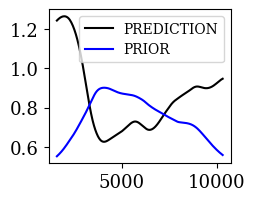

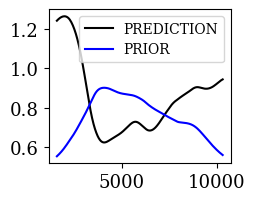

t shape: (2007, 2)
t contents: [[0.14545455 0.76329748]
 [0.14545455 0.76340647]
 [0.14545455 0.76340648]
 ...
 [0.93818182 0.76329748]
 [0.93818182 0.76340647]
 [0.93818182 0.76340648]]
points_eval min/max: [0.14545455 0.76329748] [0.93818182 0.76340648]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


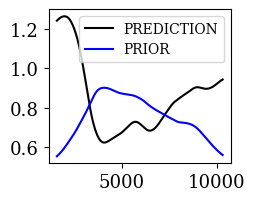

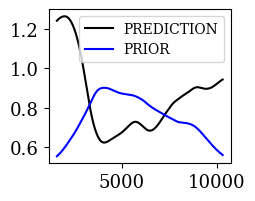

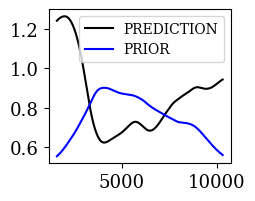

t shape: (2007, 2)
t contents: [[0.14545455 0.7734204 ]
 [0.14545455 0.77575551]
 [0.14545455 0.77592398]
 ...
 [0.93818182 0.7734204 ]
 [0.93818182 0.77575551]
 [0.93818182 0.77592398]]
points_eval min/max: [0.14545455 0.7734204 ] [0.93818182 0.77592398]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


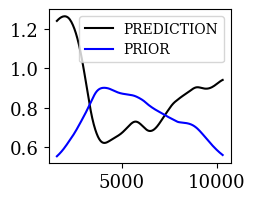

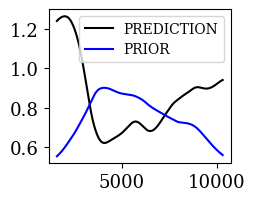

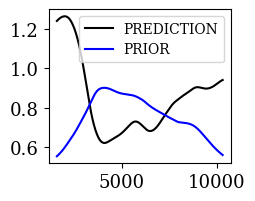

t shape: (2007, 2)
t contents: [[0.14545455 0.77592401]
 [0.14545455 0.78580158]
 [0.14545455 0.78821354]
 ...
 [0.93818182 0.77592401]
 [0.93818182 0.78580158]
 [0.93818182 0.78821354]]
points_eval min/max: [0.14545455 0.77592401] [0.93818182 0.78821354]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


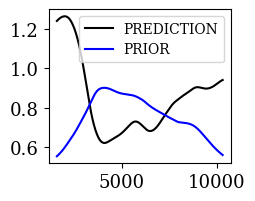

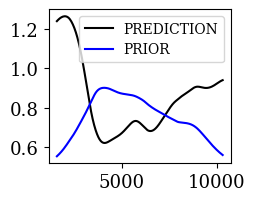

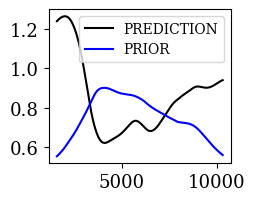

t shape: (2007, 2)
t contents: [[0.14545455 0.7884415 ]
 [0.14545455 0.78844153]
 [0.14545455 0.79818275]
 ...
 [0.93818182 0.7884415 ]
 [0.93818182 0.78844153]
 [0.93818182 0.79818275]]
points_eval min/max: [0.14545455 0.7884415 ] [0.93818182 0.79818275]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


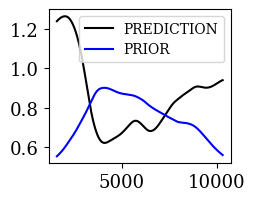

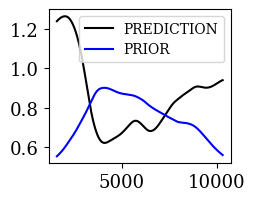

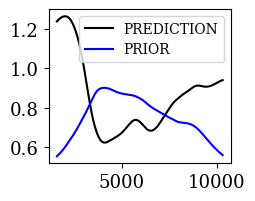

t shape: (2007, 2)
t contents: [[0.14545455 0.80067156]
 [0.14545455 0.80095901]
 [0.14545455 0.80095906]
 ...
 [0.93818182 0.80067156]
 [0.93818182 0.80095901]
 [0.93818182 0.80095906]]
points_eval min/max: [0.14545455 0.80067156] [0.93818182 0.80095906]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


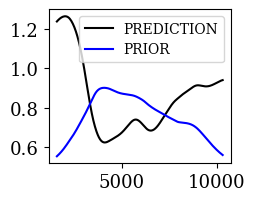

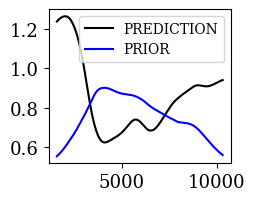

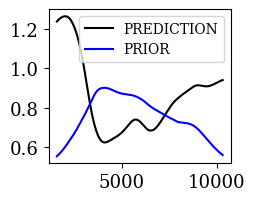

t shape: (2007, 2)
t contents: [[0.14545455 0.81056393]
 [0.14545455 0.81312959]
 [0.14545455 0.81347653]
 ...
 [0.93818182 0.81056393]
 [0.93818182 0.81312959]
 [0.93818182 0.81347653]]
points_eval min/max: [0.14545455 0.81056393] [0.93818182 0.81347653]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


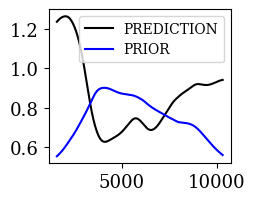

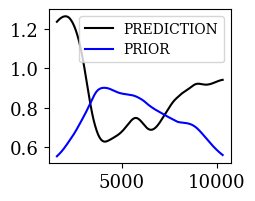

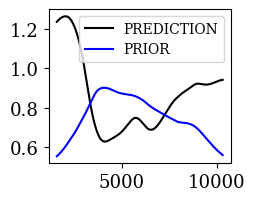

t shape: (2007, 2)
t contents: [[0.14545455 0.81347659]
 [0.14545455 0.8229451 ]
 [0.14545455 0.82558762]
 ...
 [0.93818182 0.81347659]
 [0.93818182 0.8229451 ]
 [0.93818182 0.82558762]]
points_eval min/max: [0.14545455 0.81347659] [0.93818182 0.82558762]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


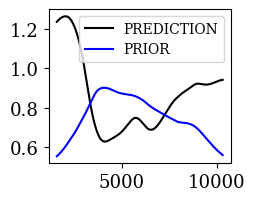

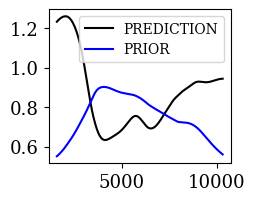

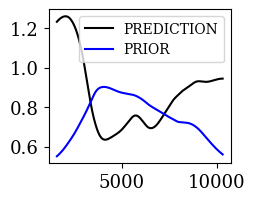

t shape: (2007, 2)
t contents: [[0.14545455 0.82599404]
 [0.14545455 0.82599411]
 [0.14545455 0.83532628]
 ...
 [0.93818182 0.82599404]
 [0.93818182 0.82599411]
 [0.93818182 0.83532628]]
points_eval min/max: [0.14545455 0.82599404] [0.93818182 0.83532628]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


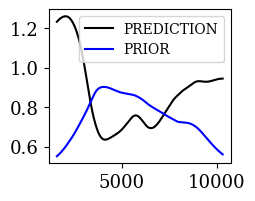

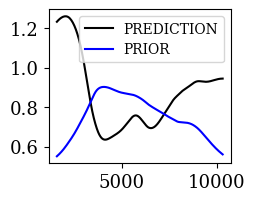

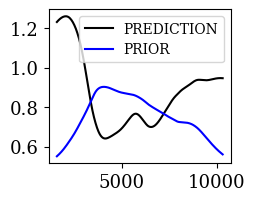

t shape: (2007, 2)
t contents: [[0.14545455 0.83804565]
 [0.14545455 0.83851155]
 [0.14545455 0.83851164]
 ...
 [0.93818182 0.83804565]
 [0.93818182 0.83851155]
 [0.93818182 0.83851164]]
points_eval min/max: [0.14545455 0.83804565] [0.93818182 0.83851164]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


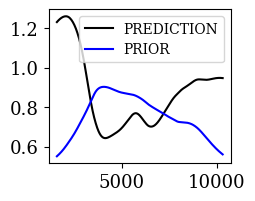

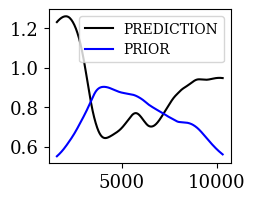

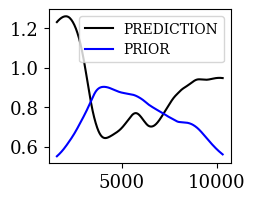

t shape: (2007, 2)
t contents: [[0.14545455 0.84770745]
 [0.14545455 0.85050367]
 [0.14545455 0.85102907]
 ...
 [0.93818182 0.84770745]
 [0.93818182 0.85050367]
 [0.93818182 0.85102907]]
points_eval min/max: [0.14545455 0.84770745] [0.93818182 0.85102907]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


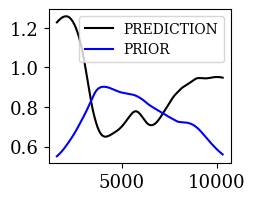

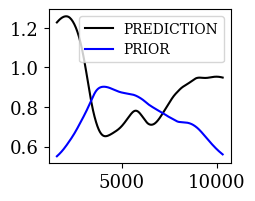

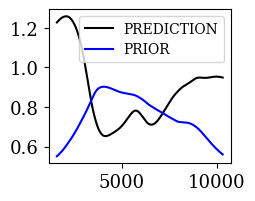

t shape: (2007, 2)
t contents: [[0.14545455 0.85102917]
 [0.14545455 0.86008863]
 [0.14545455 0.8629617 ]
 ...
 [0.93818182 0.85102917]
 [0.93818182 0.86008863]
 [0.93818182 0.8629617 ]]
points_eval min/max: [0.14545455 0.85102917] [0.93818182 0.8629617 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


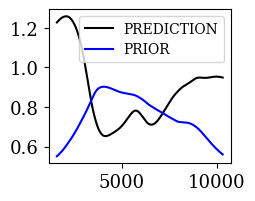

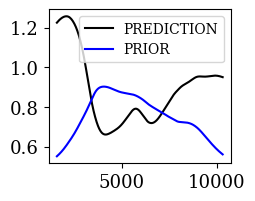

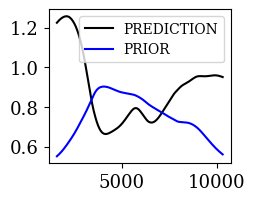

t shape: (2007, 2)
t contents: [[0.14545455 0.86354658]
 [0.14545455 0.86354669]
 [0.14545455 0.8724698 ]
 ...
 [0.93818182 0.86354658]
 [0.93818182 0.86354669]
 [0.93818182 0.8724698 ]]
points_eval min/max: [0.14545455 0.86354658] [0.93818182 0.8724698 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


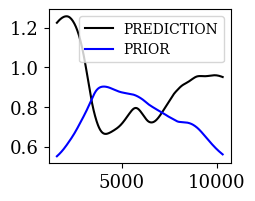

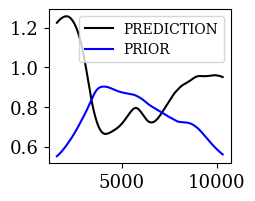

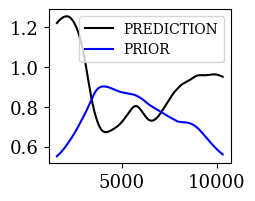

t shape: (2007, 2)
t contents: [[0.14545455 0.87541973]
 [0.14545455 0.87606409]
 [0.14545455 0.87606422]
 ...
 [0.93818182 0.87541973]
 [0.93818182 0.87606409]
 [0.93818182 0.87606422]]
points_eval min/max: [0.14545455 0.87541973] [0.93818182 0.87606422]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


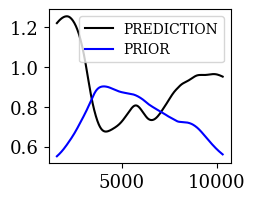

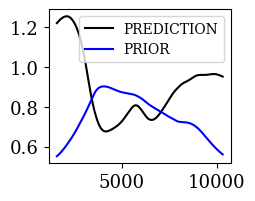

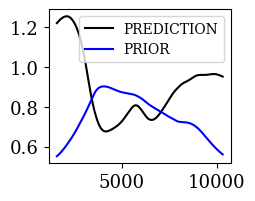

t shape: (2007, 2)
t contents: [[0.14545455 0.88485098]
 [0.14545455 0.88787776]
 [0.14545455 0.89723215]
 ...
 [0.93818182 0.88485098]
 [0.93818182 0.88787776]
 [0.93818182 0.89723215]]
points_eval min/max: [0.14545455 0.88485098] [0.93818182 0.89723215]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


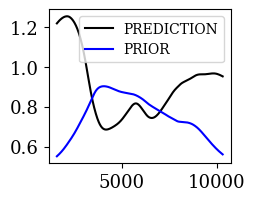

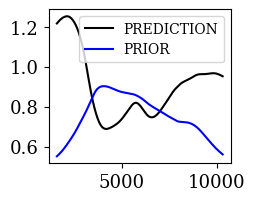

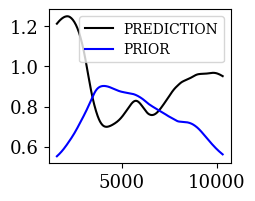

t shape: (2007, 2)
t contents: [[0.14545455 0.90033578]
 [0.14545455 0.90961333]
 [0.14545455 0.91279381]
 ...
 [0.93818182 0.90033578]
 [0.93818182 0.90961333]
 [0.93818182 0.91279381]]
points_eval min/max: [0.14545455 0.90033578] [0.93818182 0.91279381]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


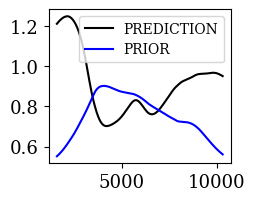

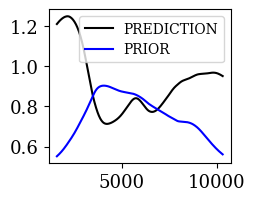

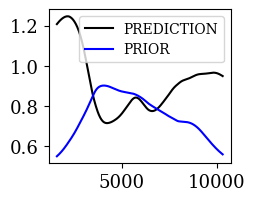

t shape: (2007, 2)
t contents: [[0.14545455 0.9219945 ]
 [0.14545455 0.92525184]
 [0.14545455 0.93437568]
 ...
 [0.93818182 0.9219945 ]
 [0.93818182 0.92525184]
 [0.93818182 0.93437568]]
points_eval min/max: [0.14545455 0.9219945 ] [0.93818182 0.93437568]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


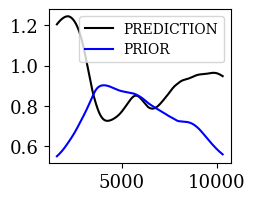

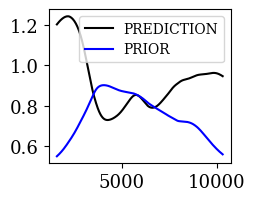

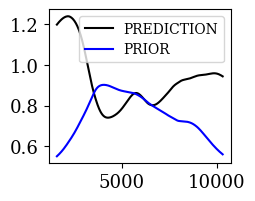

t shape: (2007, 2)
t contents: [[0.14545455 0.93770986]
 [0.14545455 0.94675685]
 [0.14545455 0.95016789]
 ...
 [0.93818182 0.93770986]
 [0.93818182 0.94675685]
 [0.93818182 0.95016789]]
points_eval min/max: [0.14545455 0.93770986] [0.93818182 0.95016789]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


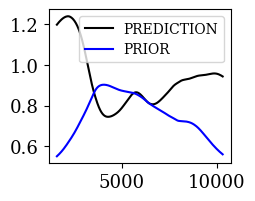

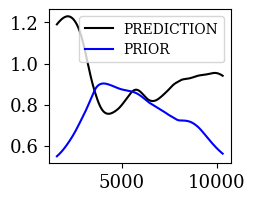

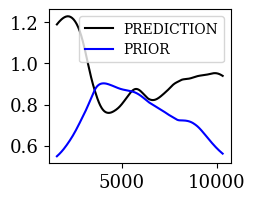

t shape: (2007, 2)
t contents: [[0.14545455 0.95913803]
 [0.14545455 0.96262592]
 [0.14545455 0.9715192 ]
 ...
 [0.93818182 0.95913803]
 [0.93818182 0.96262592]
 [0.93818182 0.9715192 ]]
points_eval min/max: [0.14545455 0.95913803] [0.93818182 0.9715192 ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


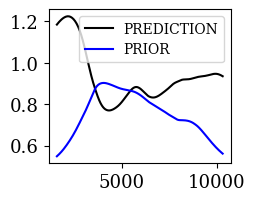

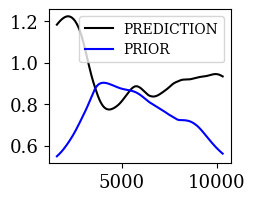

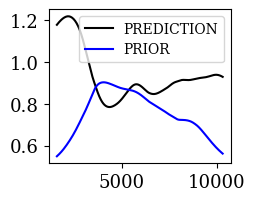

t shape: (2007, 2)
t contents: [[0.14545455 0.97508395]
 [0.14545455 0.98390038]
 [0.14545455 0.98754197]
 ...
 [0.93818182 0.97508395]
 [0.93818182 0.98390038]
 [0.93818182 0.98754197]]
points_eval min/max: [0.14545455 0.97508395] [0.93818182 0.98754197]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


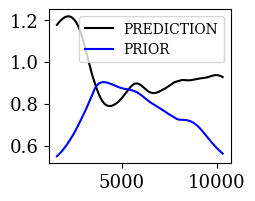

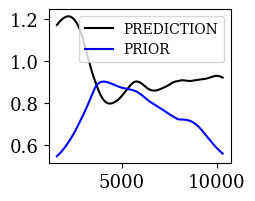

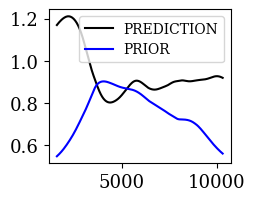

t shape: (669, 2)
t contents: [[0.14545455 1.        ]
 [0.14909091 1.        ]
 [0.15272727 1.        ]
 ...
 [0.93090909 1.        ]
 [0.93454545 1.        ]
 [0.93818182 1.        ]]
points_eval min/max: [0.14545455 1.        ] [0.93818182 1.        ]
points min/max: [0.13636364 0.00851338] [ 0.95363636 24.67173386]
grid_z1 contains NaN: False


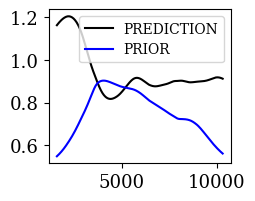

[ ********************  ]255 of 255spec extrapolated
EXTENDING SPECTRA BETWEEN:
WLS: 1600.0 10320.0
MJD: -0.3113081538322149 8.068694846107974


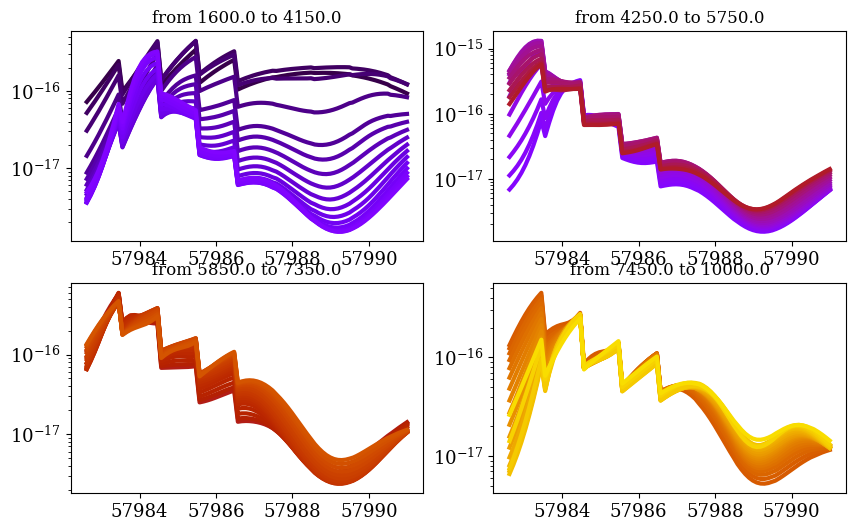

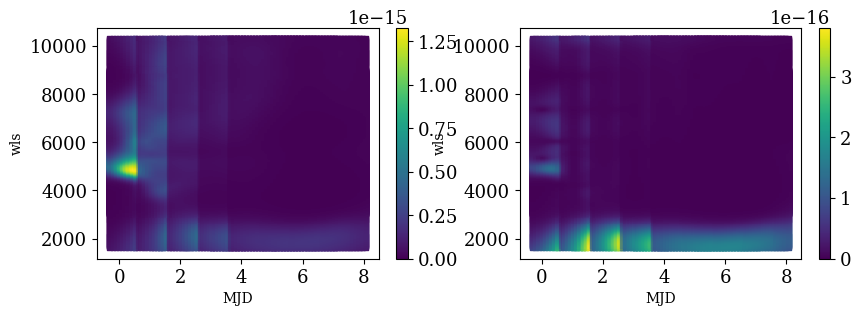

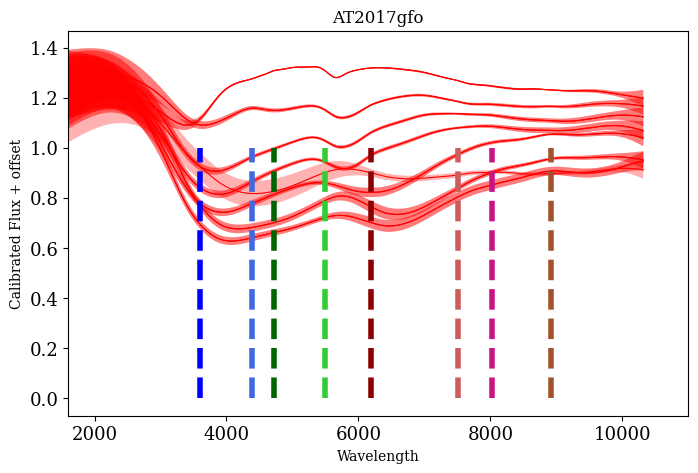

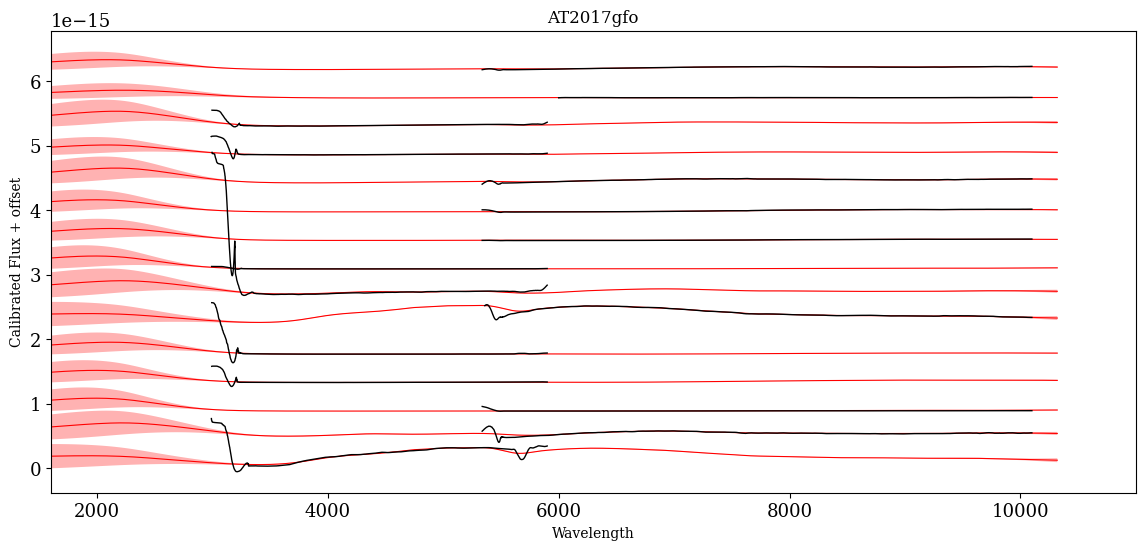

In [24]:
# Check for empty or all-NaN arrays before running GP interpolation
if (
    y_data_nonan.size == 0 or np.all(np.isnan(y_data_nonan)) or
    y_data_nonan_err.size == 0 or np.all(np.isnan(y_data_nonan_err)) or
    x1_data_norm.size == 0 or np.all(np.isnan(x1_data_norm)) or
    x2_data_norm.size == 0 or np.all(np.isnan(x2_data_norm))
):
    raise ValueError("Input data for GP interpolation contains only NaNs or is empty. Please check your data preparation steps.")

# Do the 2dim GP interpolation
x1_fill, x2_fill, mu_fill, std_fill = GP2dim.run_2DGP_GRID(
    spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,
    kernel_wls_scale, kernel_time_scale, grid_ext_columns,
    prior=True, points=Xprior, values=yprior
)

# Make some useful plots that helps to check the results
# These are saved in OUTPUT_DIR/SNname/TwoDextended_spectra
GP2dim.make_results_plots(spec_class, x1_fill, x2_fill, mu_fill, std_fill)
mu_fill_conv, std_fill_conv, y_data_conv = GP2dim.transform_back_andPlot(
    spec_class, x1_fill, x2_fill, mu_fill, std_fill, y_data_nonan
)

V band First data:0.00 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]
#######################COVARIANCE MATRIX inf


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_53935/1152011066.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  R,cov = opt.curve_fit(fit, t_, flux_, p0=p0,


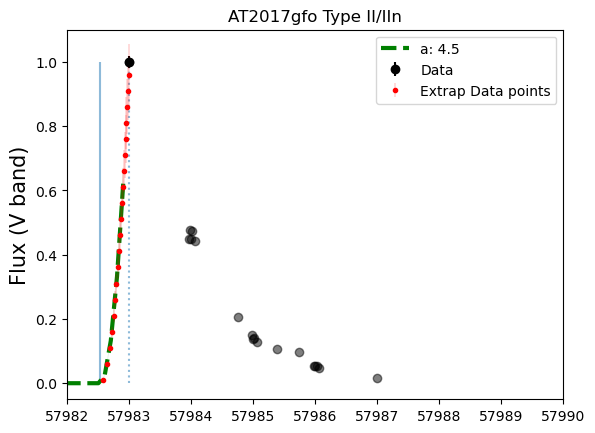

['Bessell_B', 'sdss_g', 'sdss_i', 'sdss_r', 'sdss_z']
Im extending also ['Bessell_B', 'sdss_g', 'sdss_i', 'sdss_r', 'sdss_z'] 

Bessell_B First data:0.00 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]
#######################COVARIANCE MATRIX inf


sdss_g First data:-0.39 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]


sdss_i First data:0.00 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]
#######################COVARIANCE MATRIX inf


sdss_r First data:0.00 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]
#######################COVARIANCE MATRIX inf


sdss_z First data:0.00 Max point used for fitting:0.00
Fitting ['a'] Initial guess [0.5]
#######################COVARIANCE MATRIX inf




/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_53935/1152011066.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  R,cov = opt.curve_fit(fit, t_, flux_, p0=p0,
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_53935/1152011066.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  R,cov = opt.curve_fit(fit, t_, flux_, p0=p0,
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_53935/1152011066.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  R,cov = opt.curve_fit(fit, t_, flux_, p0=p0,


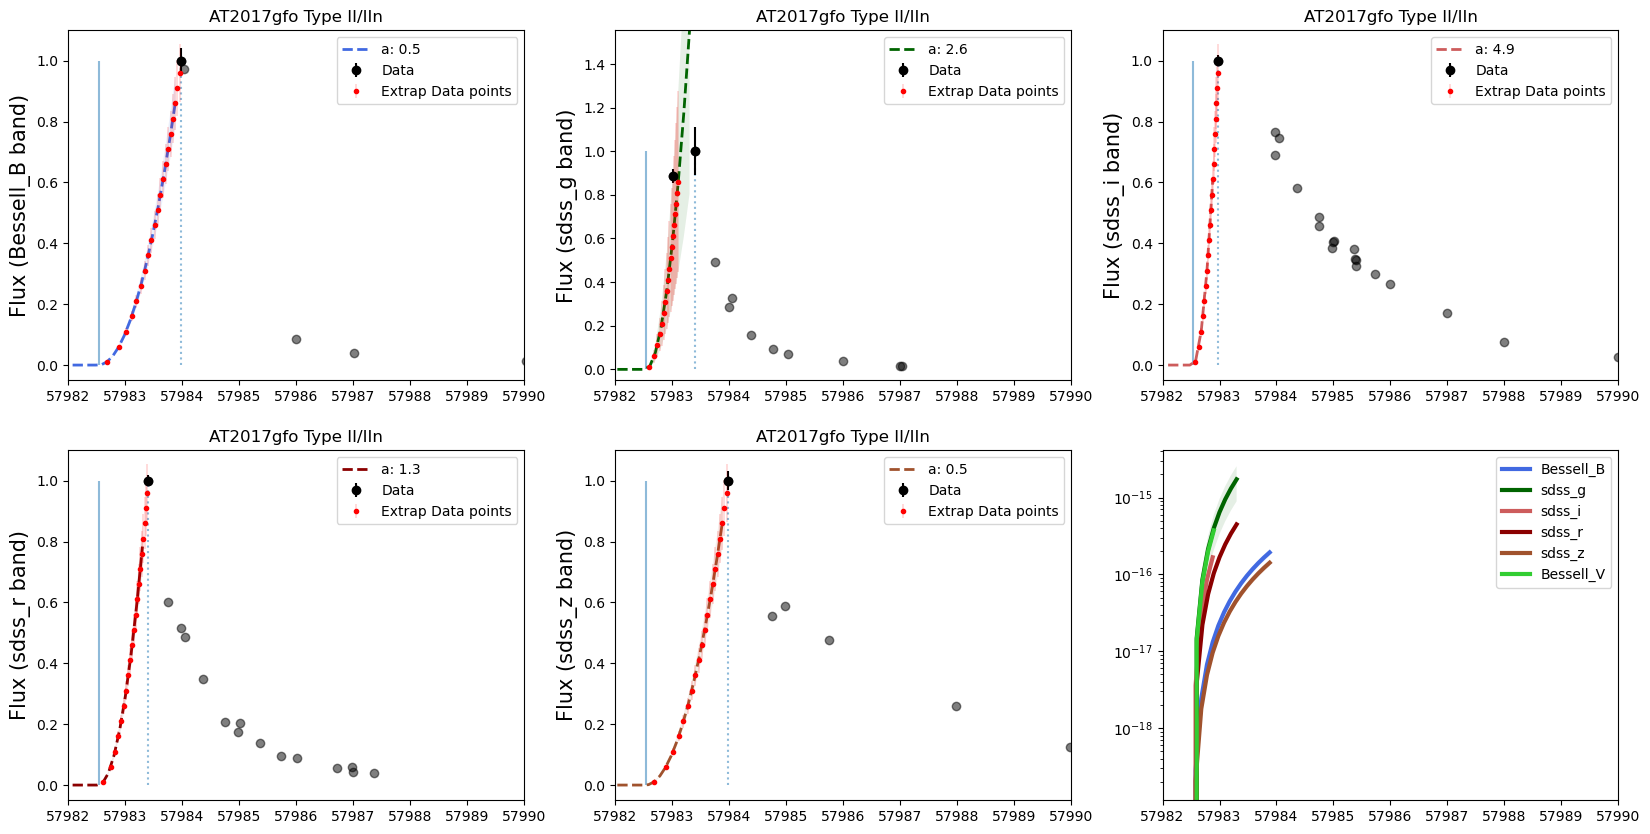

In [ ]:
original_phot = pd.DataFrame(SN.phot.copy())
extr_pts_pd = pd.DataFrame(columns=original_phot.columns)#.reindex_like(clipped_phot)[:0]

# Extrapolate BAND V first
band_init = 'Bessell_V' if snname not in noBessellV_useswiftV else 'swift_V'
flux_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['Flux']
fluxerr_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['Flux_err']
t_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['MJD']

mjd_Vpeak = t_V[np.argmax(flux_V)]
Vpeak = max(flux_V)
if snname in pre_bump.keys():
    mjd_Vpeak = explosion_dates[snname][0]+pre_bump[snname][0]
    Vpeak = max(flux_V[t_V>min(t_V)+pre_bump[snname][0]])

plt.plot(t_V, flux_V/Vpeak, 'ok', alpha=0.5)
    
window = 1.0  # days
if np.count_nonzero(flux_V[t_V<=mjd_Vpeak]<=0.8*Vpeak)>=2:
    max_MJD = max(t_V[t_V<=mjd_Vpeak][flux_V[t_V<=mjd_Vpeak]<=0.8*Vpeak])
else:
    max_MJD = mjd_Vpeak
    #max_MJD = min(t_V) + window
print ('V band', 'First data:%.2f'%(min(t_V)-mjd_Vpeak), 'Max point used for fitting:%.2f'%(max_MJD-mjd_Vpeak))

t_ = t_V[t_V<=max_MJD]
phase_ = t_ - mjd_Vpeak
flux_ = flux_V[t_V<=max_MJD]/Vpeak
fluxerr_ = fluxerr_V[t_V<=max_MJD]/Vpeak
plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

# FIT
R, cov, t_extrapV, fittedV, fittedV_err, t_newpts, newpts_, newpts_err, label_dict, success = performe_fit(snname, band_init, t_, flux_, fluxerr_, phase_, mjd_Vpeak)
    
plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
plt.ylabel('Flux (V band)', fontsize=15)
        
plt.plot(t_extrapV, fittedV, 'g--', lw=3, label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
plt.fill_between(t_extrapV, fittedV-fittedV_err, fittedV+fittedV_err,
                 facecolor='g', alpha=0.1)

plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2, label='Extrap Data points')

plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
if snname in pre_bump.keys(): plt.xlim((explosion_dates[snname][0]-2.),20.+mjd_Vpeak)
    
if snname in se_sne: plt.title(snname+ '_SESN')
else: plt.title(snname+ ' Type II/IIn')
plt.ylim(-0.05, max(max(fittedV),1.1))
plt.xlim(57982, 57990)
plt.legend()
plt.show()
    
if success:
    extr_pts_pd['MJD'] = t_newpts
    extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band_init)
    extr_pts_pd['Flux'] = newpts_*Vpeak
    extr_pts_pd['Flux_err'] = newpts_err*Vpeak
    extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
    extr_pts_pd['Instr'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
    #original_phot = original_phot.append(extr_pts_pd)
    original_phot = pd.concat([original_phot, extr_pts_pd], ignore_index=True)
else: print ('Something went wrong')
    
i=1
early_bands=[]
exclude_bands = exclude_dict[snname] if snname in exclude_dict else []
include_bands = include_dict[snname] if snname in include_dict else []
#print(np.unique(SN.clipped_phot['band']))
for band in np.unique(SN.clipped_phot['band']):
    t_x = SN.clipped_phot[SN.clipped_phot['band']==band]['MJD']
    #print(f"{band}: min(t_x)={min(t_x)}, min(t_V)={min(t_V)}, max_MJD={max_MJD}, t_x_before_maxMJD={t_x[t_x<=max_MJD]}")
    #if (min(t_x)<=min(t_V)+2.0)&(len(t_x[t_x<=max_MJD])>=1):
    #rav changed this line
    if (min(t_x)<=min(t_V)+2.0)&(len(t_x[t_x<=max(t_V)+1.0])>=1):
        if (snname in se_sne)&(band not in [band_init, 'swift_UVW1','swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            early_bands.append(band)
        elif (snname not in se_sne)&(band not in [band_init, 'swift_U', 'Bessell_U', 'swift_UVW1',
                                           'swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            early_bands.append(band)
    if (band in include_bands):
        if band not in early_bands: early_bands.append(band)

N_rows = int(len(early_bands)/3)+1
fig = plt.figure(figsize=(20,N_rows*5))
print(early_bands)
print ('Im extending also', early_bands, '\n')
for band in early_bands:
    plt.subplot(N_rows,3,i)
    
    flux_x = SN.clipped_phot[SN.clipped_phot['band']==band]['Flux']
    fluxerr_x = SN.clipped_phot[SN.clipped_phot['band']==band]['Flux_err']
    t_x = SN.clipped_phot[SN.clipped_phot['band']==band]['MJD']
    xpeak = max(flux_x)
    mjd_xpeak = t_x[np.argmax(flux_x)]
    if snname in pre_bump.keys():
        mjd_xpeak = explosion_dates[snname][0]+pre_bump[snname][0]
        xpeak = max(flux_x[t_x>mjd_xpeak])
        
    plt.plot(t_x, flux_x/xpeak, 'ok', alpha=0.5)
    
    if np.count_nonzero(flux_x[t_x<=mjd_xpeak]<=0.8*xpeak)>=2:
        max_MJD = max(t_x[t_x<=mjd_xpeak][flux_x[t_x<=mjd_xpeak]<=0.8*xpeak])
    else:
        max_MJD = mjd_xpeak
    print (band, 'First data:%.2f'%(min(t_x)-mjd_xpeak), 'Max point used for fitting:%.2f'%(max_MJD-mjd_xpeak))

    t_ = t_x[t_x<=max_MJD]
    phase_ = t_ - mjd_xpeak
    flux_ = flux_x[t_x<=max_MJD]/xpeak
    fluxerr_ = fluxerr_x[t_x<=max_MJD]/xpeak
    #plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
    plt.xlim(57982, 57990)
    if snname in pre_bump.keys(): plt.xlim((explosion_dates[snname][0]-2.),20.+mjd_Vpeak)
    plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

    results = performe_fit(snname, band, t_, flux_, fluxerr_, phase_, mjd_xpeak)
    R, cov, t_extrap, fitted, fitted_err, t_newpts, newpts_, newpts_err, label_dict, success= results
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
    
    plt.ylabel('Flux (%s band)'%band, fontsize=15)
    plt.plot(t_extrap, fitted, '--', color=color_dict[band], lw=2,
             label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
    plt.fill_between(t_extrap, fitted-fitted_err, fitted+fitted_err,
                 facecolor=color_dict[band], alpha=0.1)
    plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2, label='Extrap Data points')
    plt.ylim(-0.05, max(max(fitted),1.1))
    
    if snname in se_sne: plt.title(snname+ '_SESN')
    else: plt.title(snname+ ' Type II/IIn')
    plt.legend()
    i=i+1
   
    if success:
        extr_pts_pd = pd.DataFrame(columns=original_phot.columns)#.reindex_like(clipped_phot)[:0]
        extr_pts_pd['MJD'] = t_newpts
        extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band)
        extr_pts_pd['Flux'] = newpts_ * xpeak
        extr_pts_pd['Flux_err'] = newpts_err * xpeak
        extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        extr_pts_pd['Instr'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        #original_phot = original_phot.append(extr_pts_pd) 
        original_phot = pd.concat([original_phot, extr_pts_pd], ignore_index=True)
    else: print ('Something went wrong')
    
    plt.subplot(N_rows,3,N_rows*3)
    plt.plot(t_extrap, fitted*xpeak, '-', color=color_dict[band], lw=3, label=band)
    plt.fill_between(t_extrap, (fitted-fitted_err)*xpeak, (fitted+fitted_err)*xpeak,
                         facecolor=color_dict[band], alpha=0.1)
    print ('\n')
plt.subplot(N_rows,3,N_rows*3)
plt.plot(t_extrapV, fittedV*Vpeak, '-', color=color_dict['Bessell_V'], lw=3,
                 label='Bessell_V')
plt.fill_between(t_extrapV, Vpeak*(fittedV-fittedV_err), Vpeak*(fittedV+fittedV_err),
                     facecolor=color_dict[band], alpha=0.1)
#plt.xlim(min(min(t_extrapV)-3., -25.+mjd_Vpeak),10.+mjd_Vpeak)
plt.xlim(57982, 57990)

plt.legend()
plt.yscale('log')
plt.xlim(57982, 57990)
plt.show()
plt.close(fig)
    
original_phot.to_csv(OUTPUT_PATH+'/%s.dat'%snname, na_rep='nan',
              index=False, sep='\t')




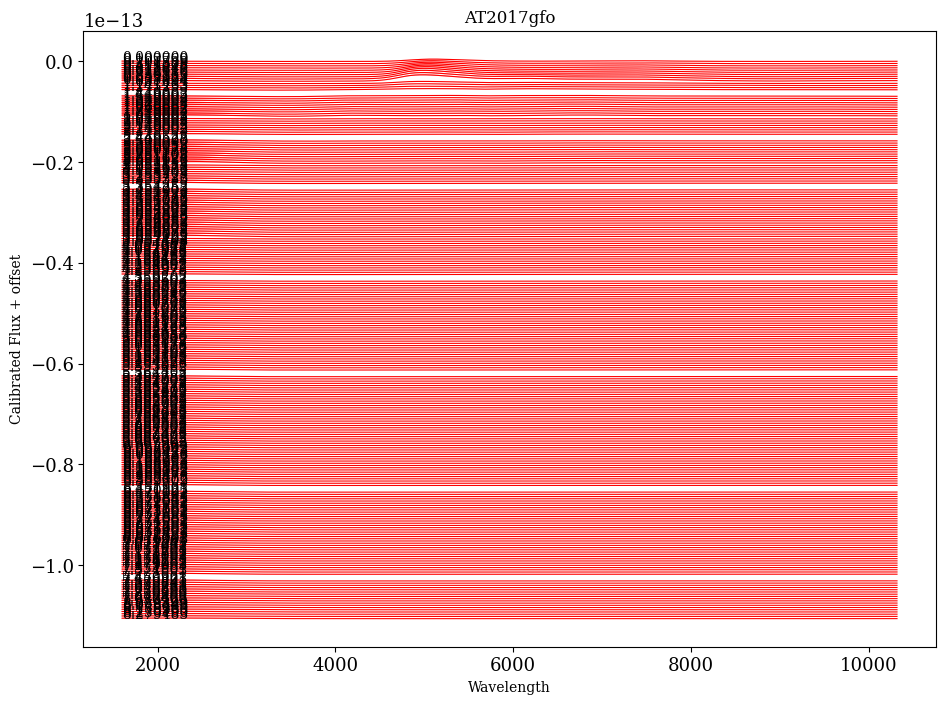

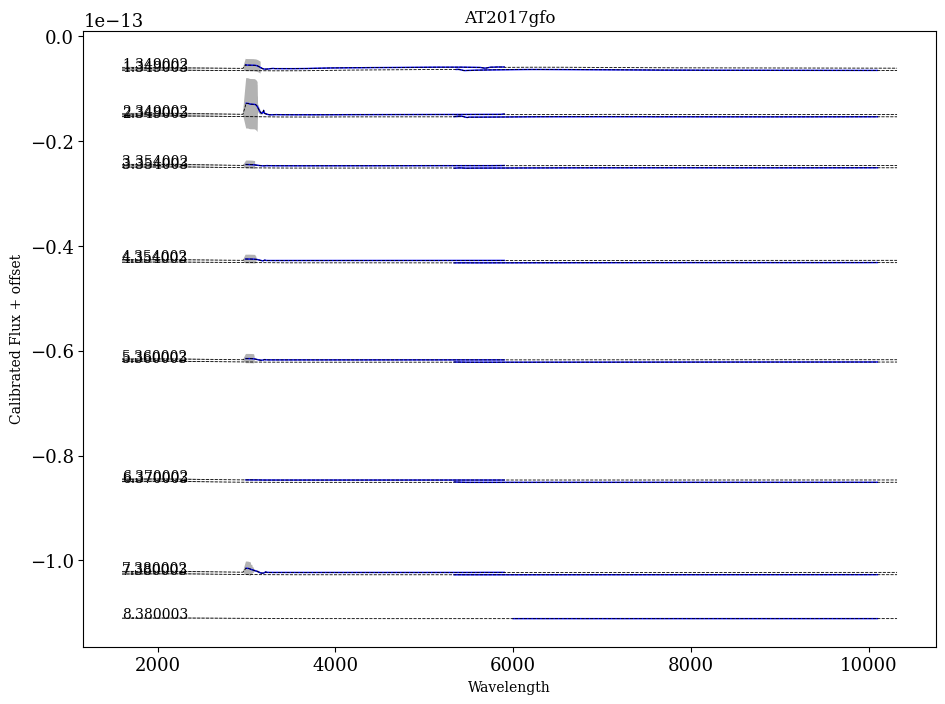

In [25]:
GP2dim.save_plots_files(spec_class, grid_ext_columns, y_data_conv, x1_fill, x2_fill, 
                        mu_fill_conv, std_fill_conv)
spec_class.mode = 'extend_spectra'
GP2dim.save_plots_files(spec_class, grid_ext_columns, y_data_conv, x1_fill, x2_fill, 
                                mu_fill_conv, std_fill_conv)